# Objectives:

Investigate declumping with images cropped in from C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700.png.

<img src="C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_show_crops_text.png">

# Takeaways:

Cropping the larger image down to these denser regions seems to improve spot detection and declumping. Clumpiness is also less prevalent. Additionally, cluster size is bimodally distributed (as we commonly observed with simulated images), suggesting bimodally distributed cluster size is a characteristic of "better" annotations.

#### Original Size (700 x 450)
| Image | # Spots detected | # Spots total | Detection rate |
|------|------|------|------|
|700|124|268|0.46|
|700 inv|150|268|0.56|

#### Crops (150 x 150)
| Crop | # Spots detected | # Spots total | Detection rate |
|------|------|------|------|
|1|64|77|0.83|
|1 inv|62|77|0.81|
|2|59|64|0.92|
|2 inv|65|64|1.02|
|3|44|50|0.46|
|3 inv|60|50|1.20|

**Overdetection:** Some clusters/detections don't actually correspond with reference spots. Often these are clusters that just happened to pick up stray annotations that are further from actual spots. Often these clusters are clumpy.

# Next steps:

- Overdetection: Can the size or spread of a cluster be used to determine whether it is a bad cluster that just happened to pick up annotations from multiple other clusters?
- How do parameters like crop size and inverted/not affect the performance of this process? 
- Explore: algorithms other than k-means to see if they perform even better
- Explore: flagging areas that need more zoomed-in annotation by detecting regions with a lot of clumpiness

# The plots in this notebook:

For each image, the following figures are shown:
- The smFISH image with no annotations.
- The smFISH image with all annotations colored by worker.
- The smFISH image with all annotations colored by worker and all clusters found by Affinity Propagation.
- Histogram sorting each cluster by the number of unique contributors.
- The smFISH image with small clusters omitted. Annotations are colored by cluster membership.
- The smFISH image with small clusters omitted. Centroids are colored analogously with the previous figure.
- Histogram sorting each cluster by the fraction of contributing workers who contribute only once to the cluster. The clumpiness threshold is shown.
- The smFISH image with small clusters omitted. Annotations are colored by membership in clumpy vs nonclumpy clusters.
- The smFISH image with small clusters omitted. Centroids are colored by membership in clumpy vs nonclumpy clusters.
- For each clumpy cluster in the image: 
    - The smFISH image zoomed in on the clumpy cluster.
    - The smFISH image zoomed in on the declumped cluster

I went ahead and generated these visualizations for all the images in the same notebook so that I could quickly scroll up and down to see if my observations for any given image generalize to other images. I tried to organize all these plots a little bit so they look less like a pile of plots, and you can navigate to different images by searching for the image name (e.g. ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_300.png).

In [1]:
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from BaseAnnotation import BaseAnnotation
from QuantiusAnnotation import QuantiusAnnotation
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from skimage import filters

%matplotlib inline

worker_marker_size = 8
cluster_marker_size = 40
bigger_window_size = True
img_height = 150
show_correctness = False
show_correctness_workers = False
show_correctness_clusters = False
show_NN_inc = False
show_ref_points = False
csv_filepath = None
correctness_threshold = None
show_possible_clumps = False
show_ref_points = False
clustering_params = ['AffinityPropagation', -350]

------------- C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop1.png -------------


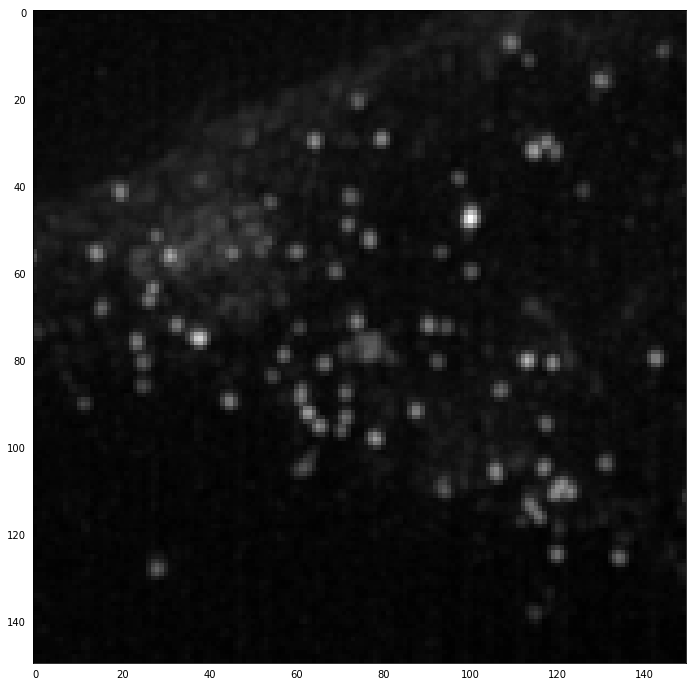

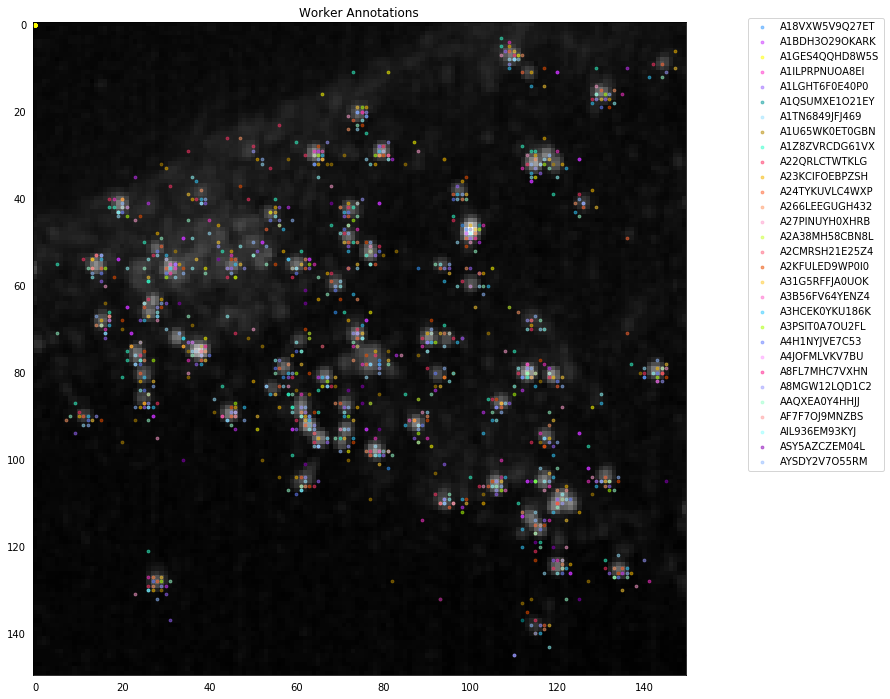

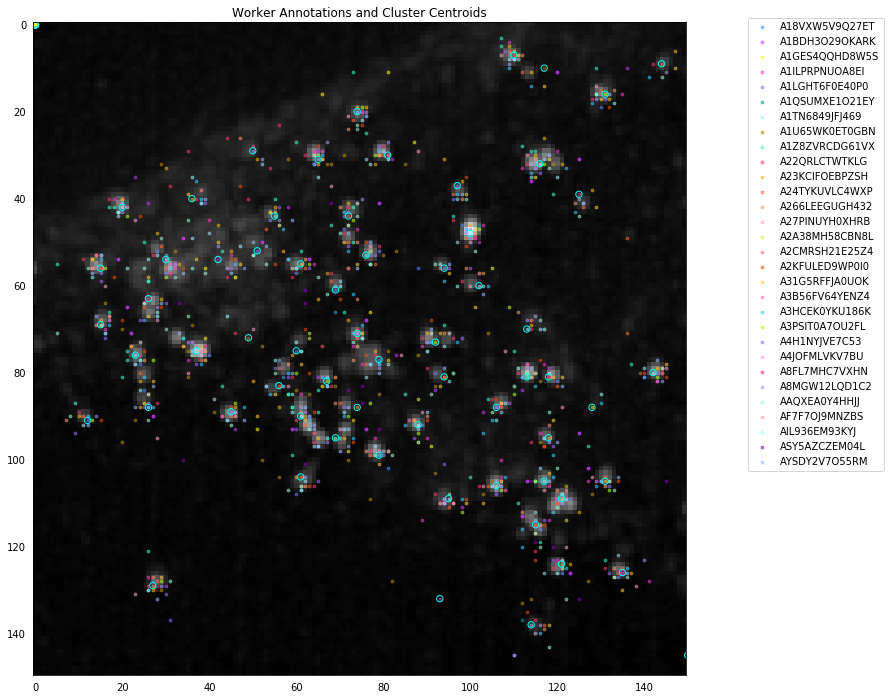

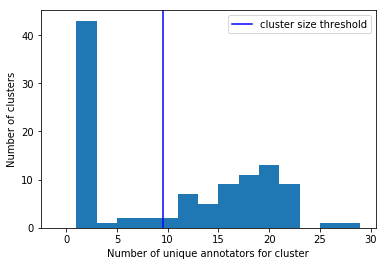

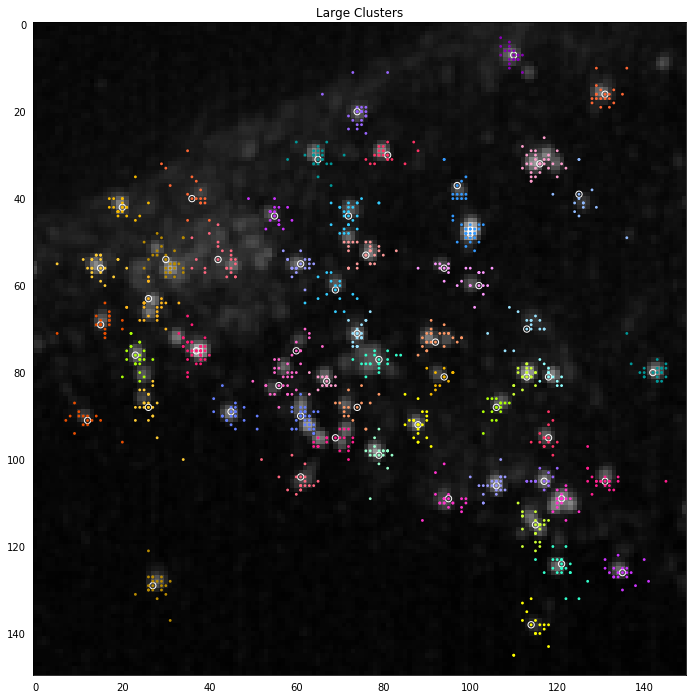

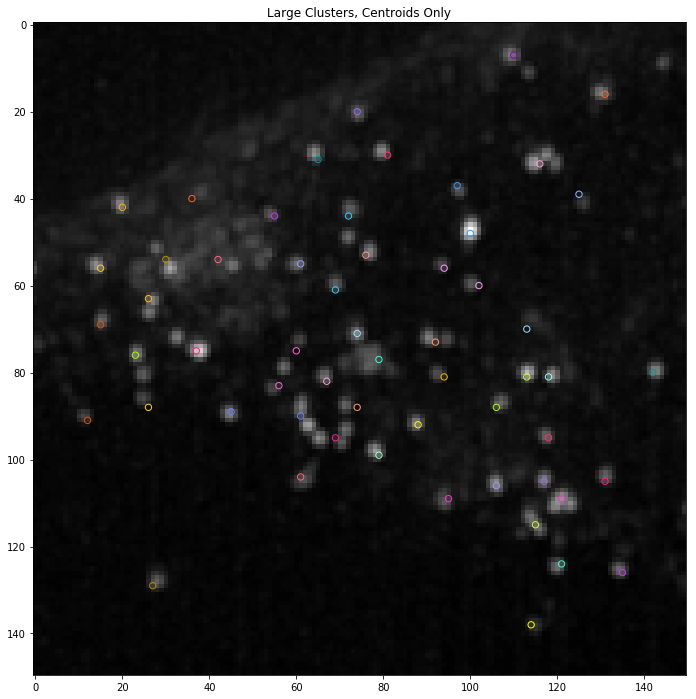

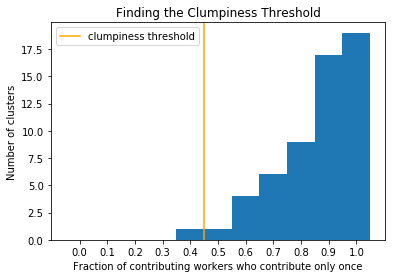

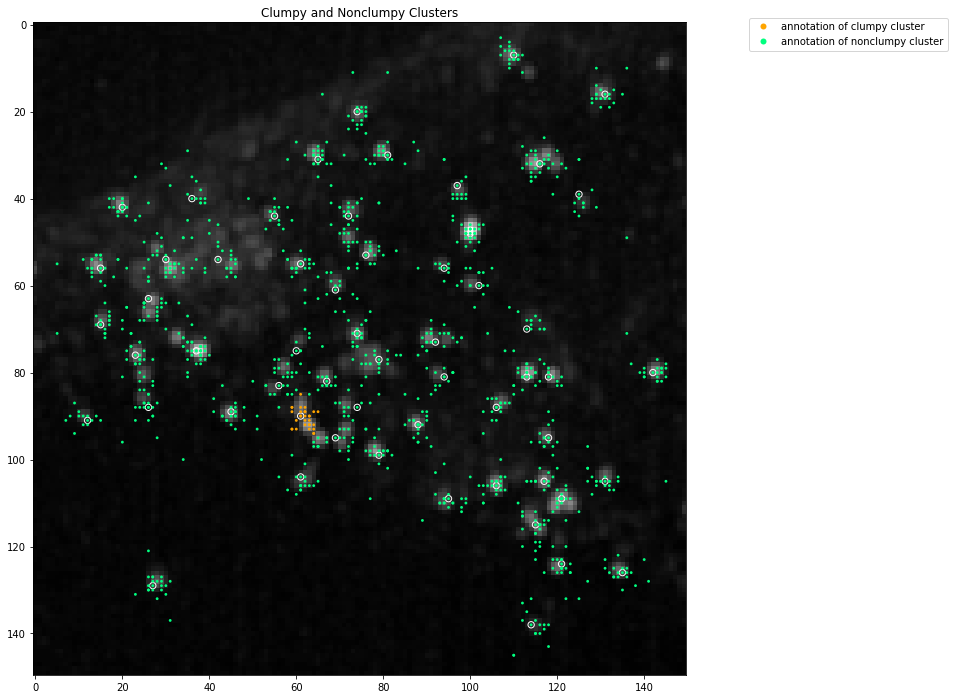

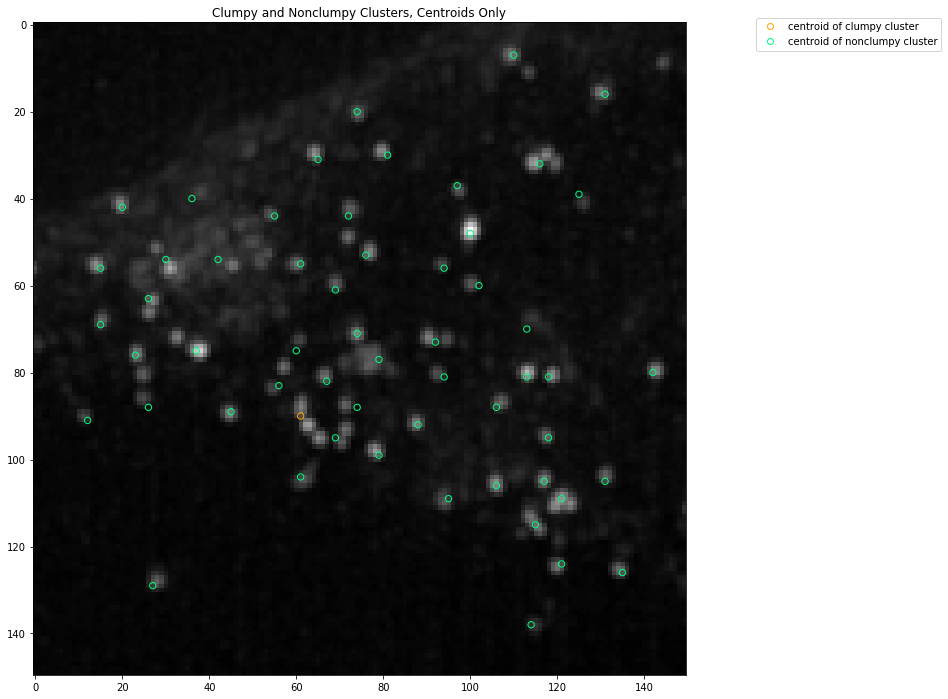

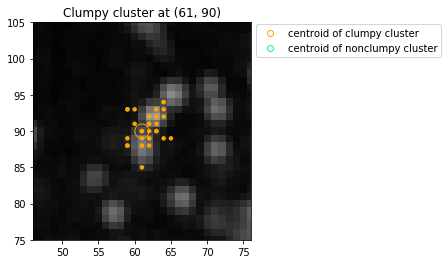

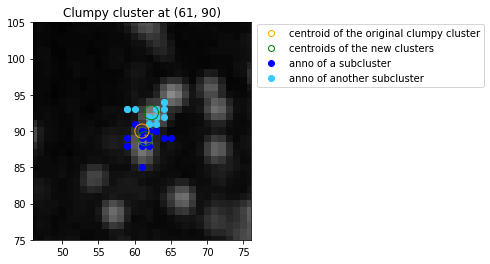

------------- C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop1_inv.png -------------


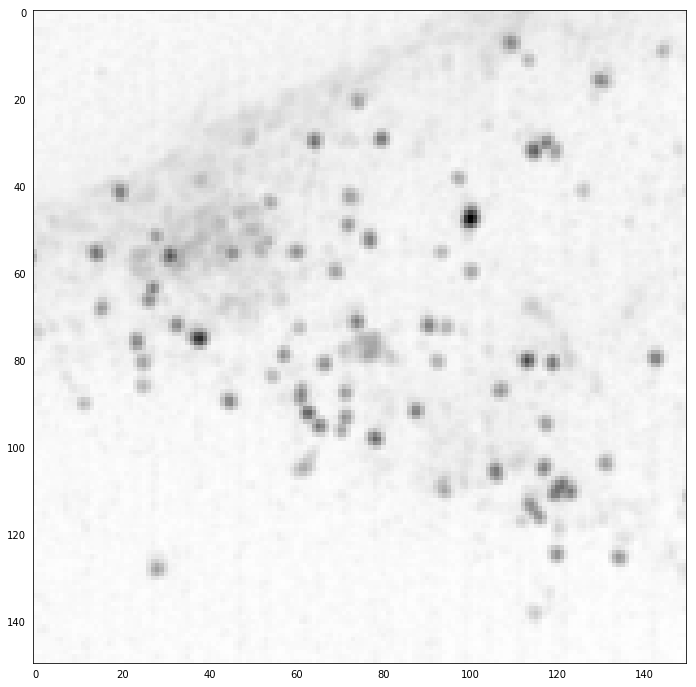

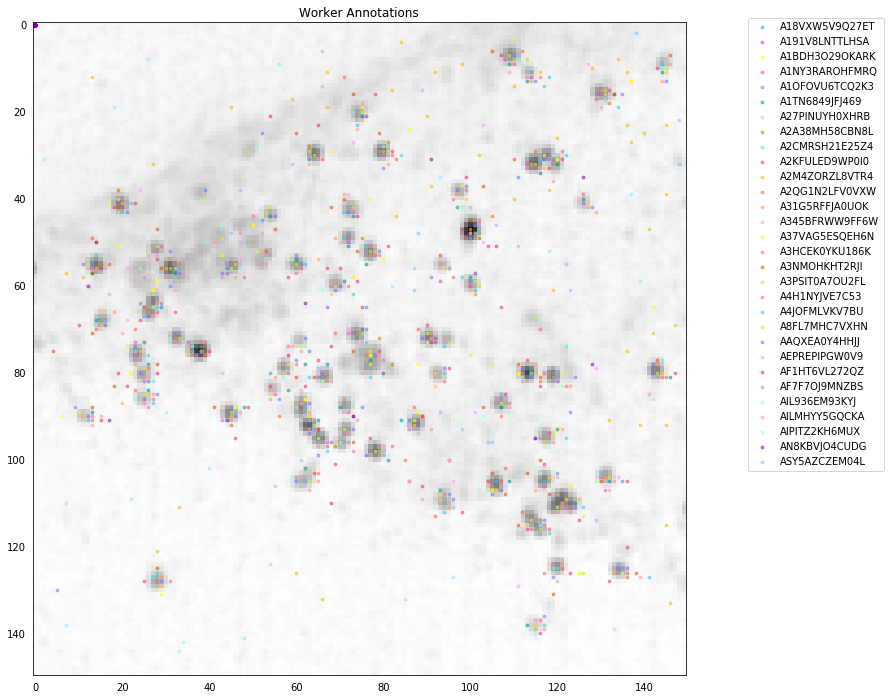

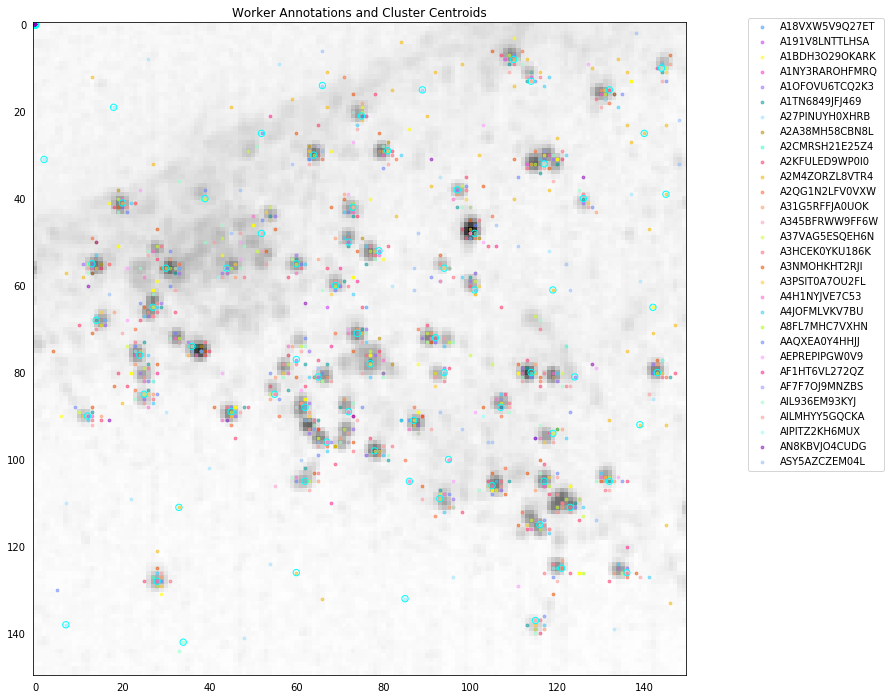

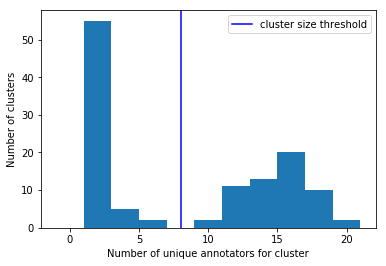

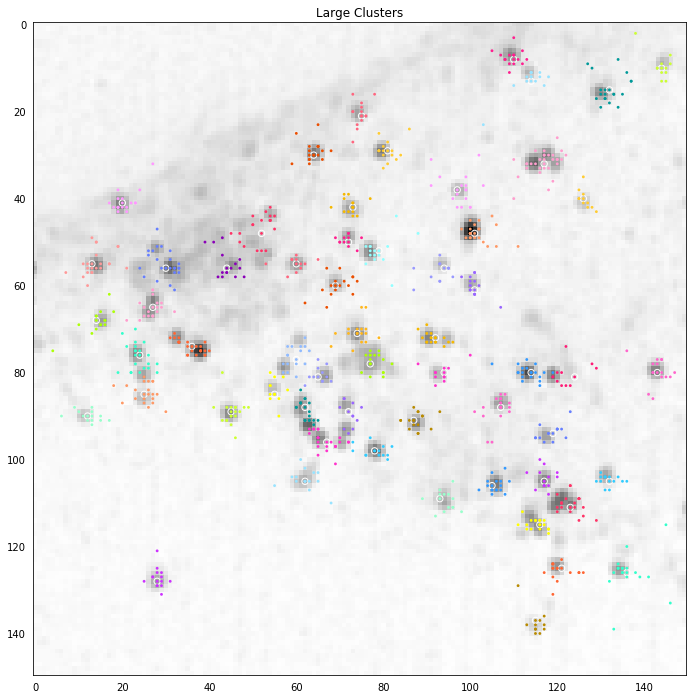

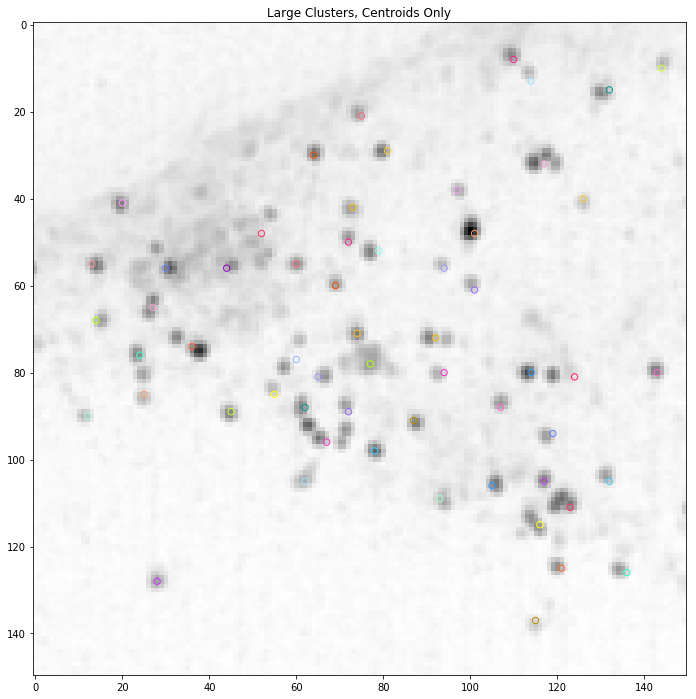

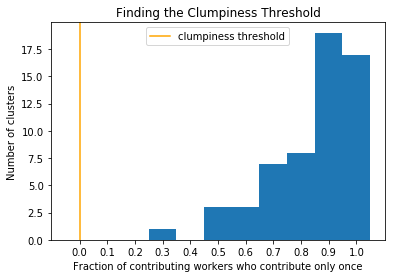

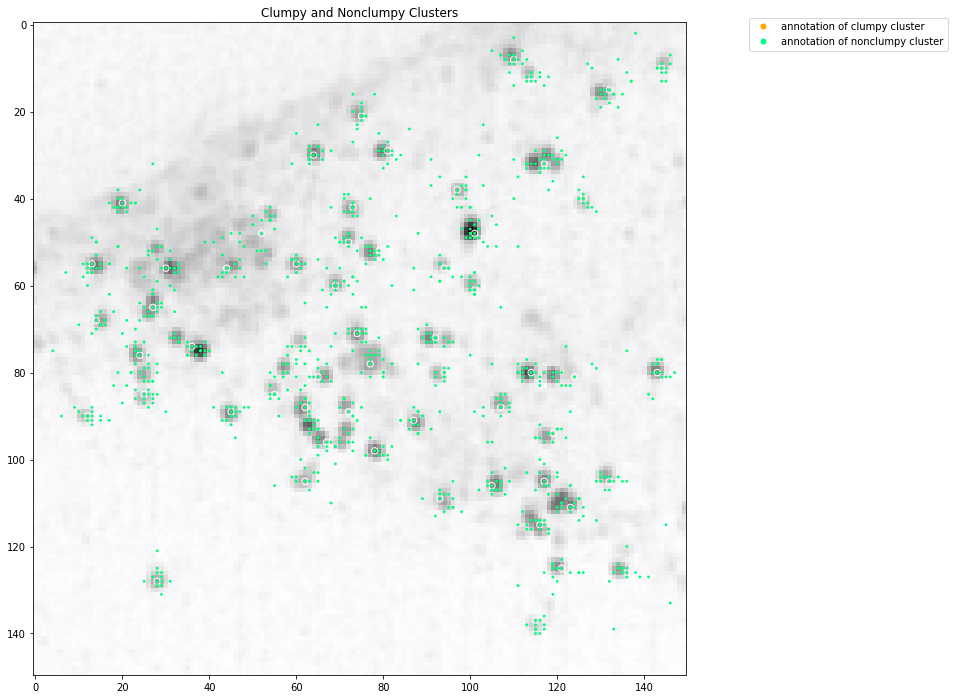

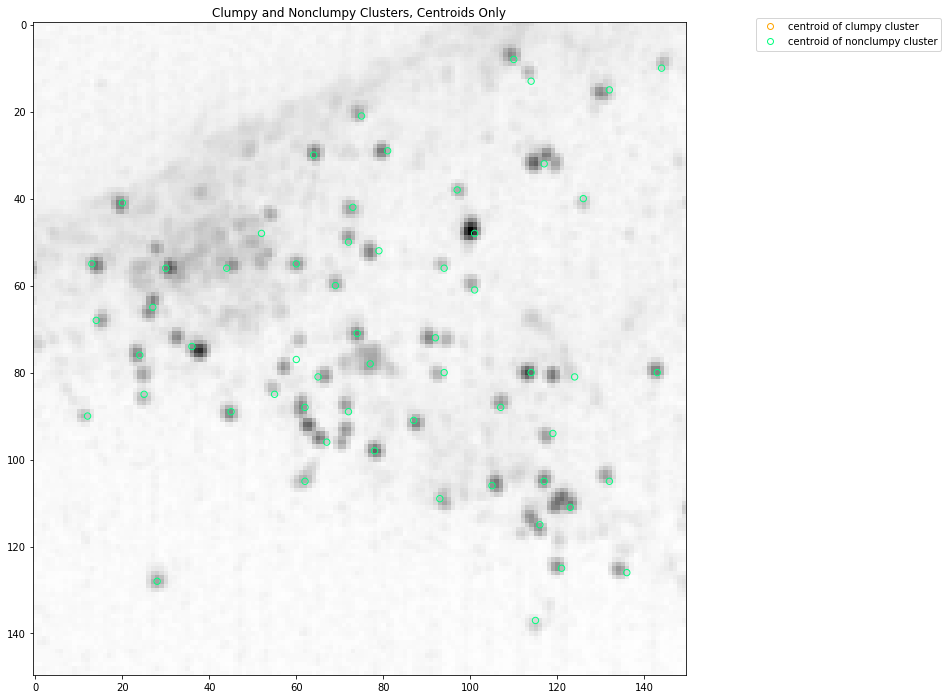

------------- C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop2.png -------------


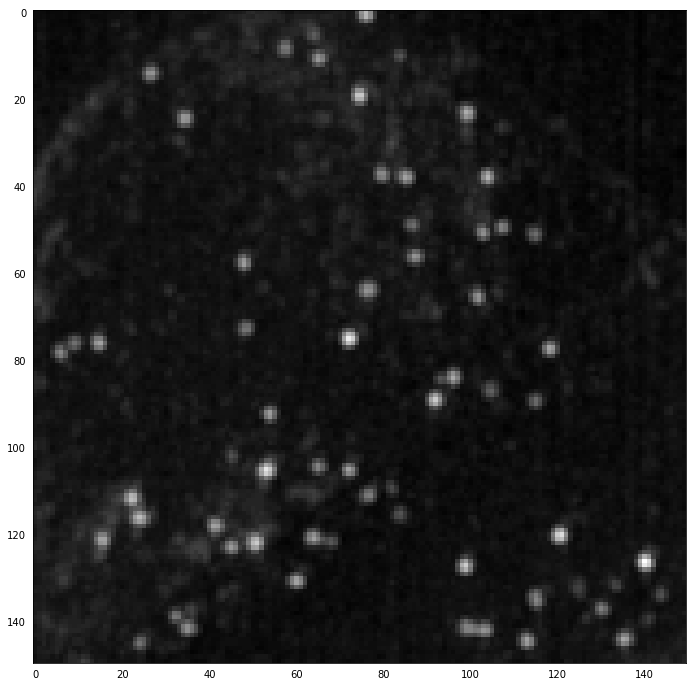

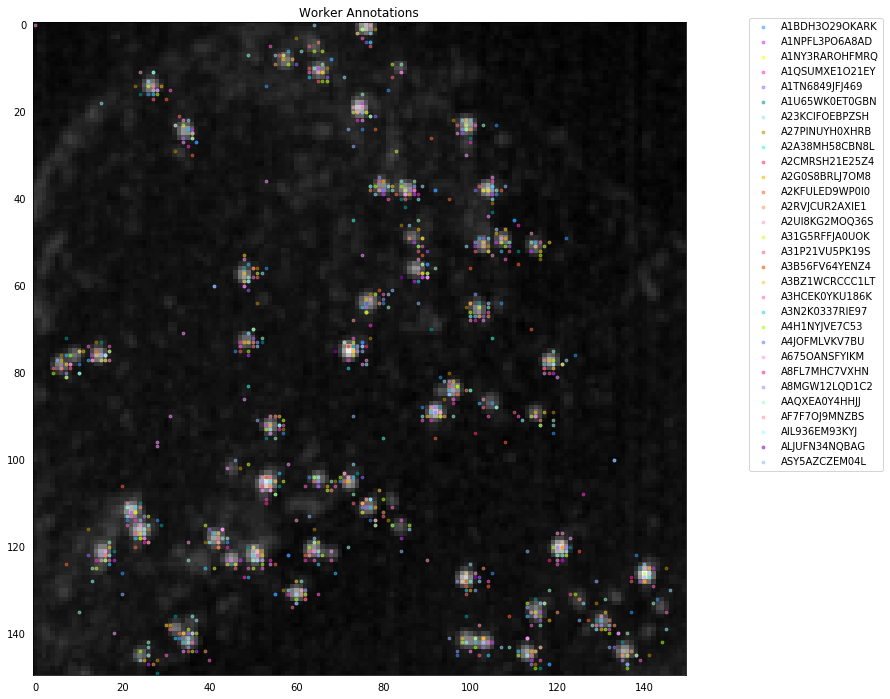

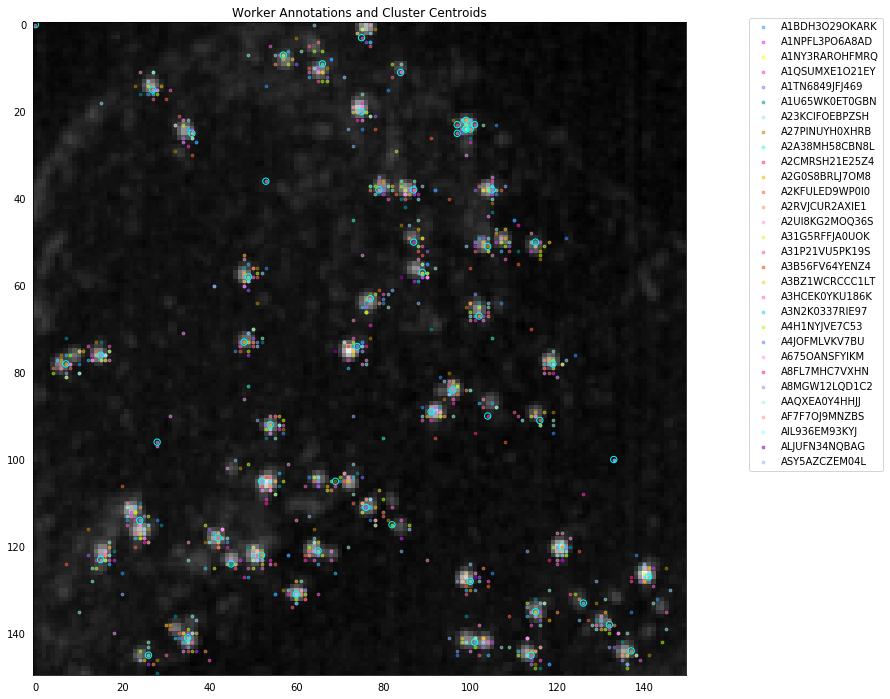

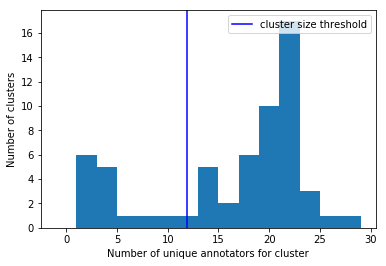

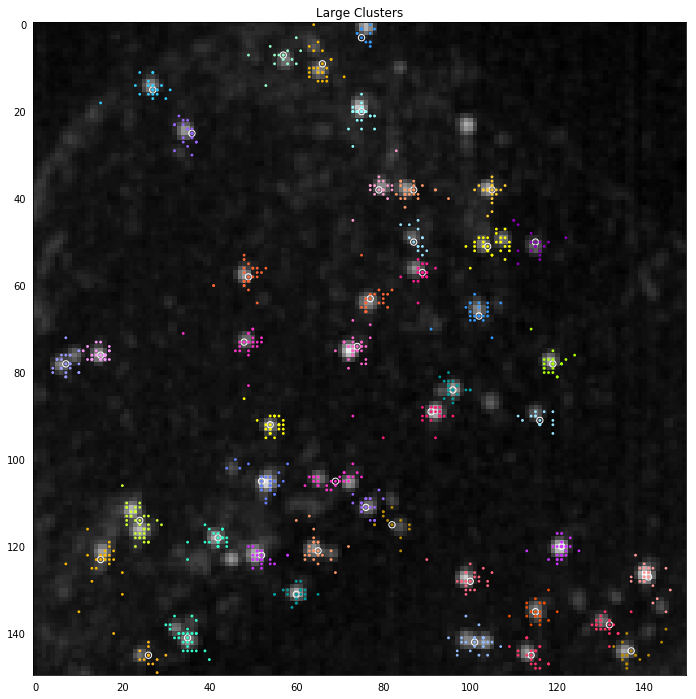

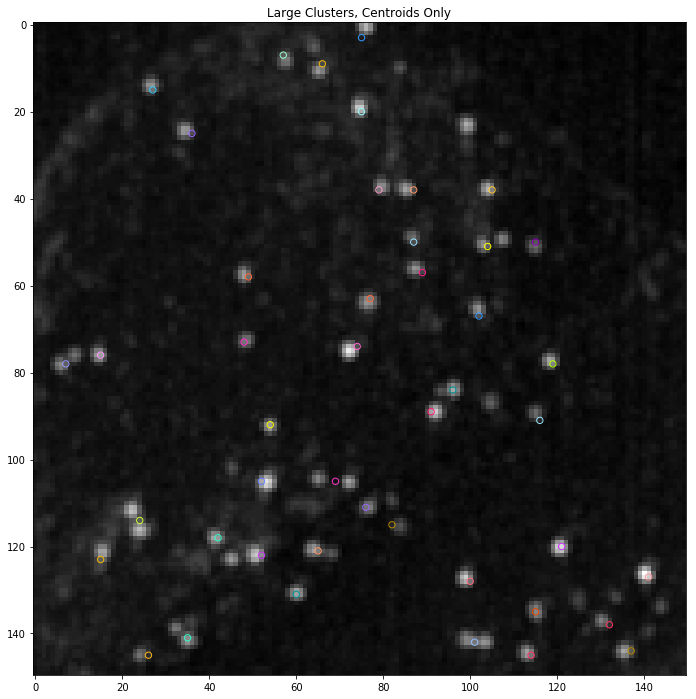

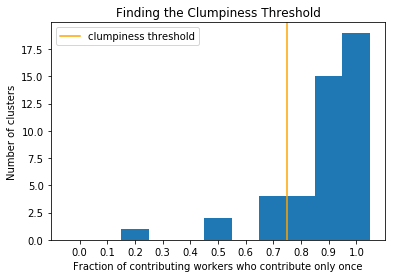

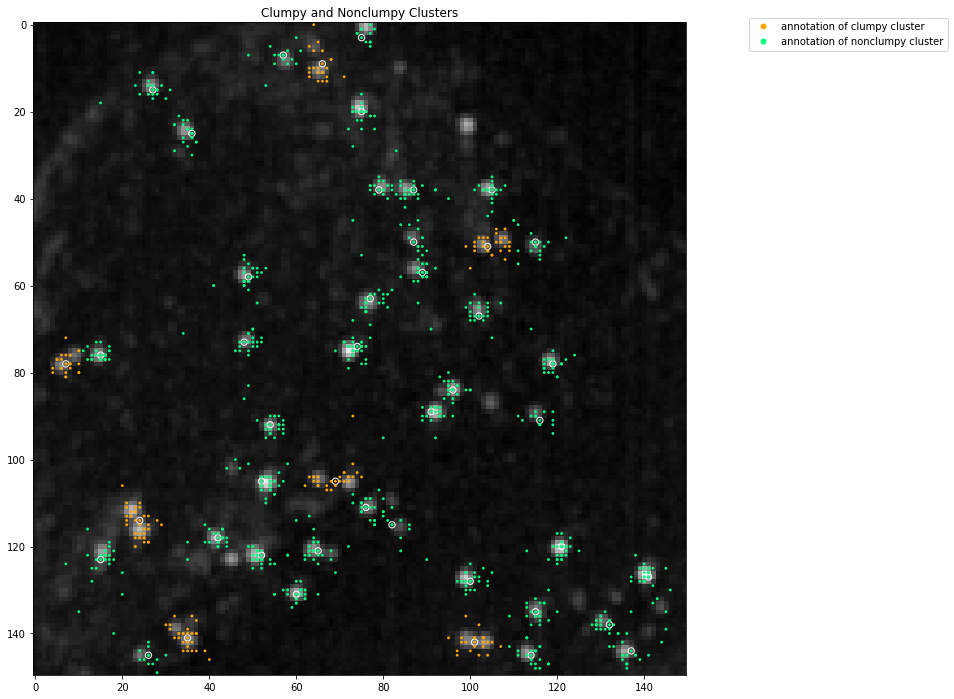

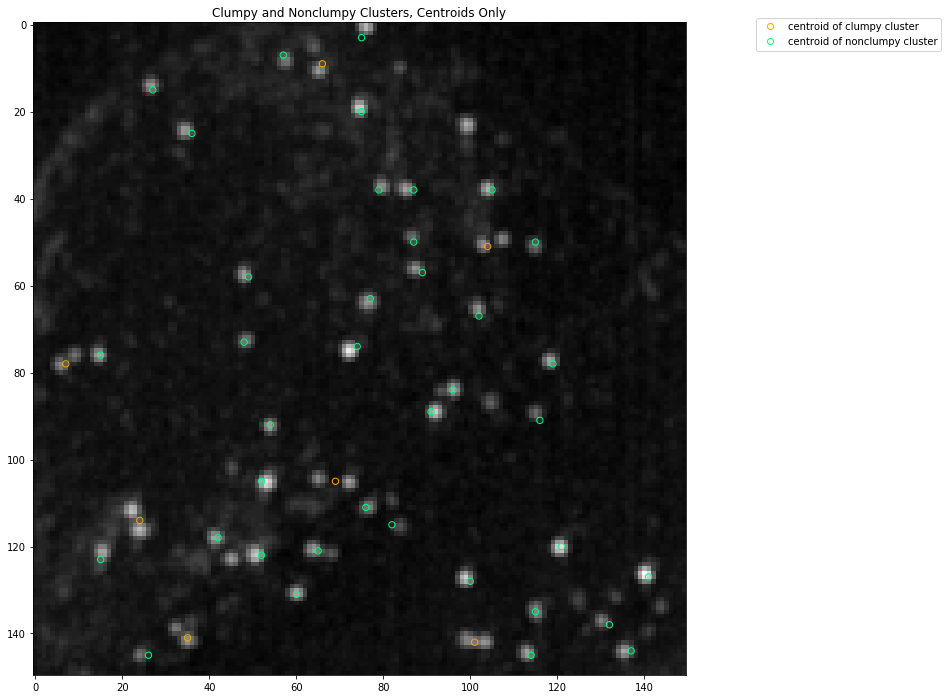

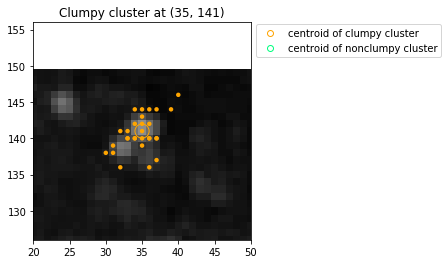

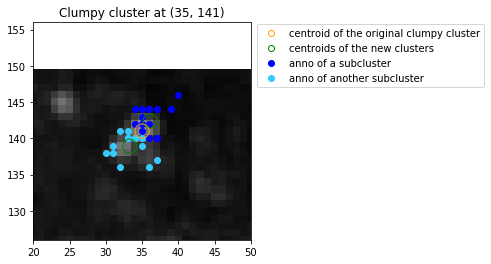

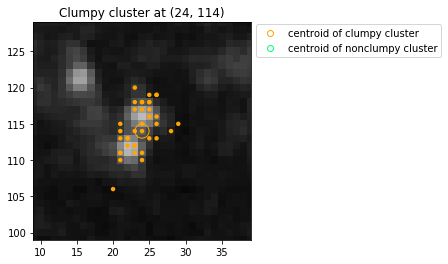

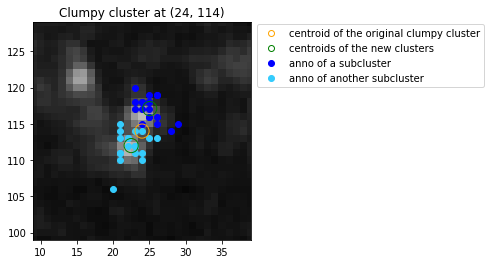

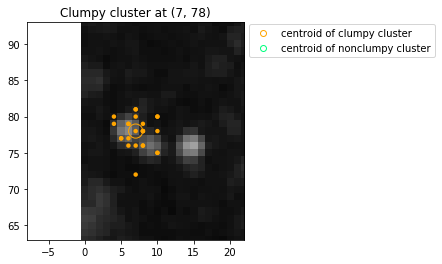

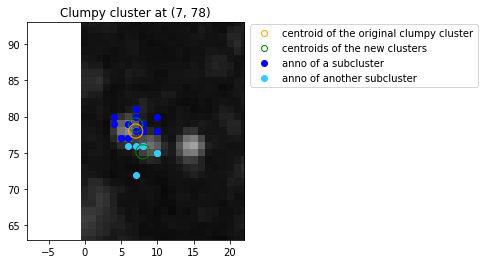

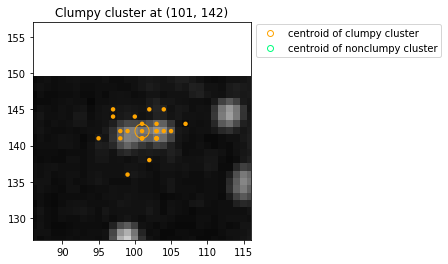

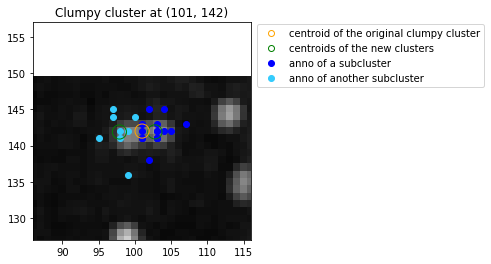

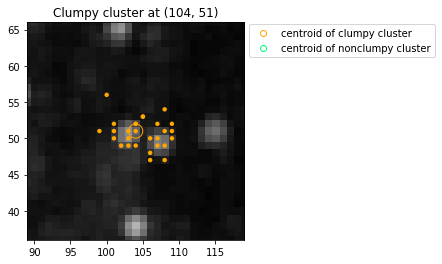

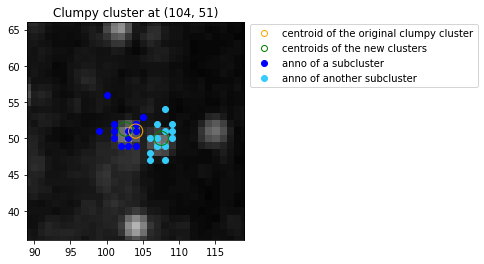

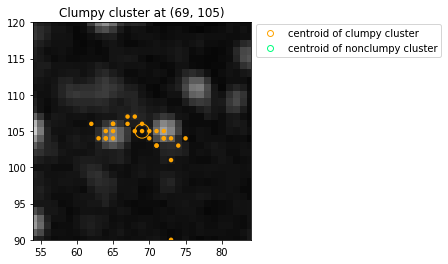

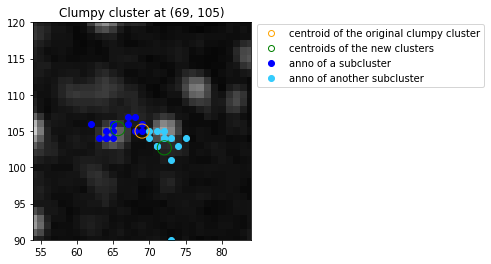

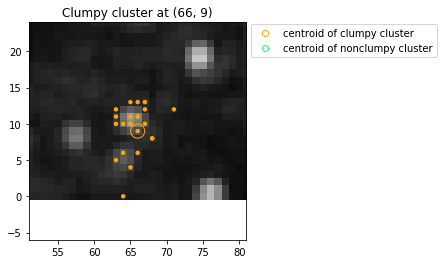

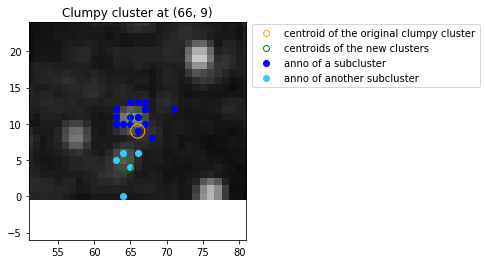

------------- C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop2_inv.png -------------


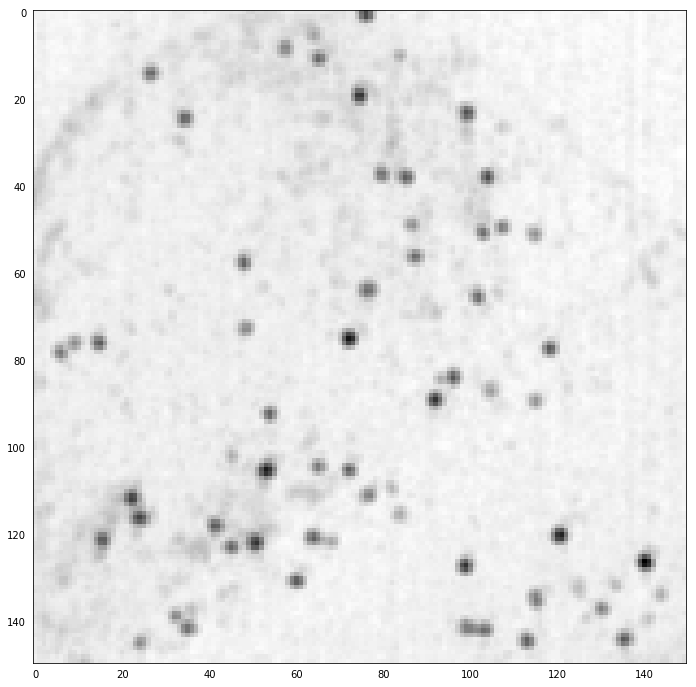

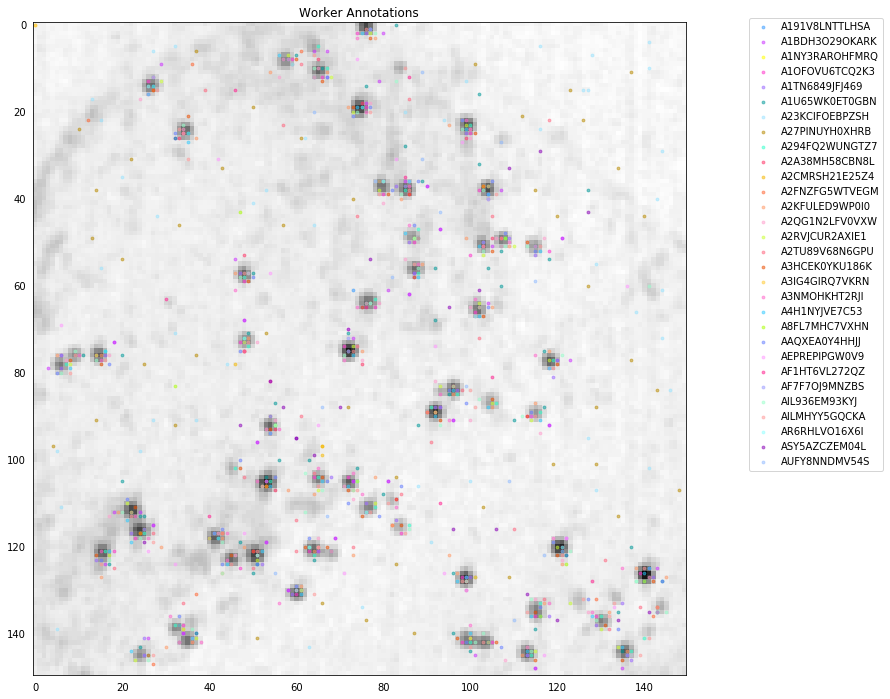

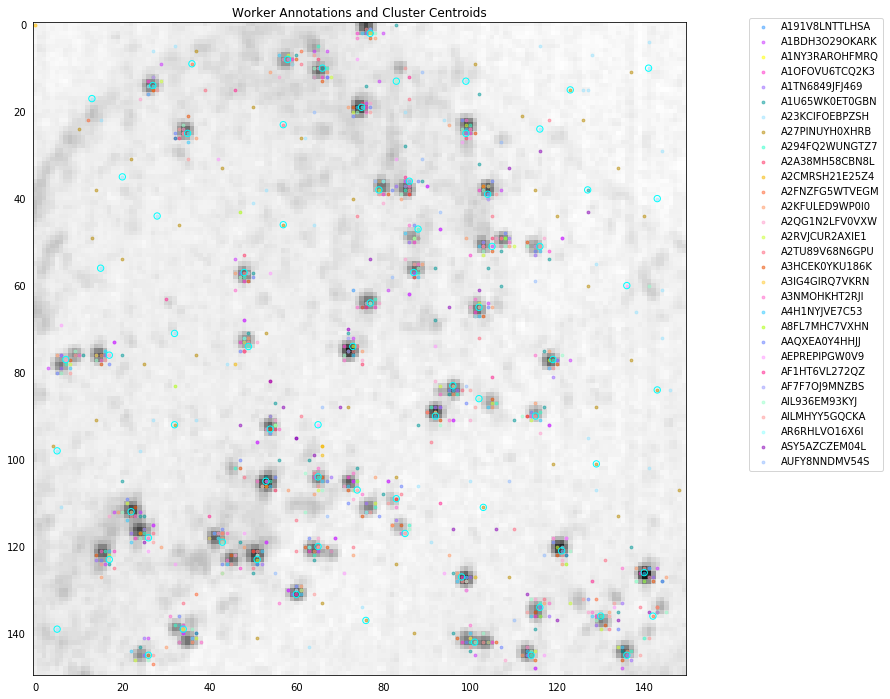

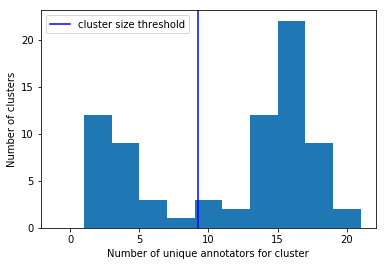

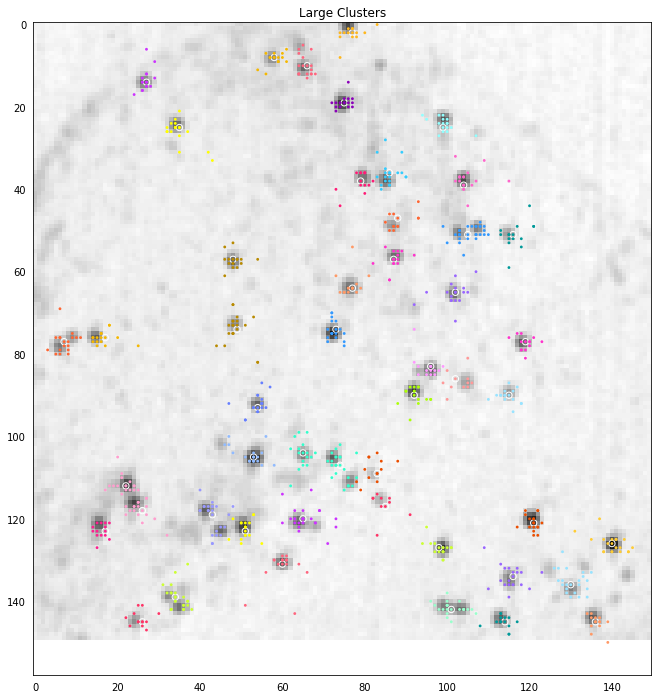

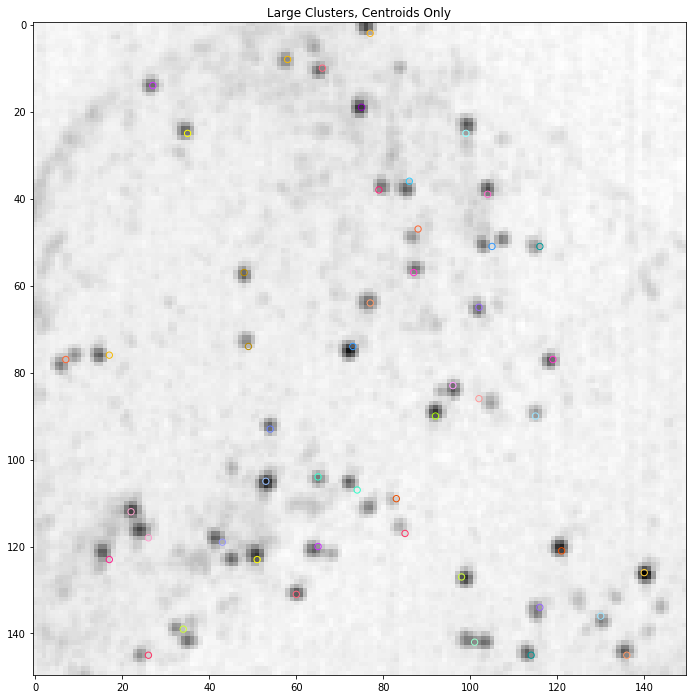

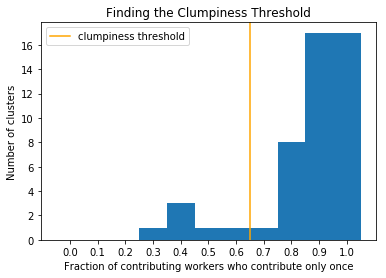

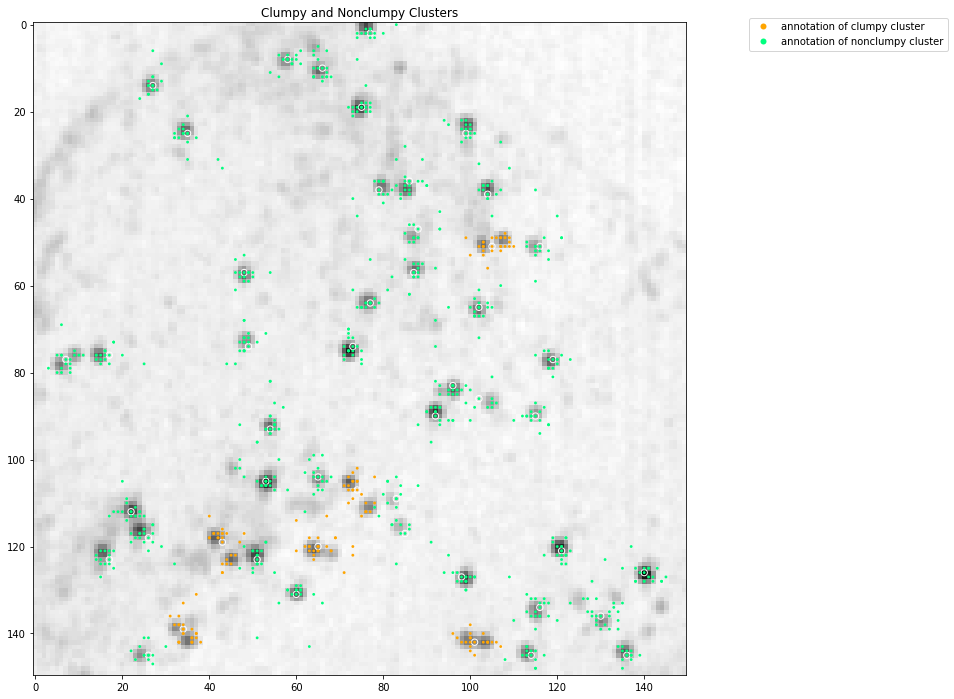

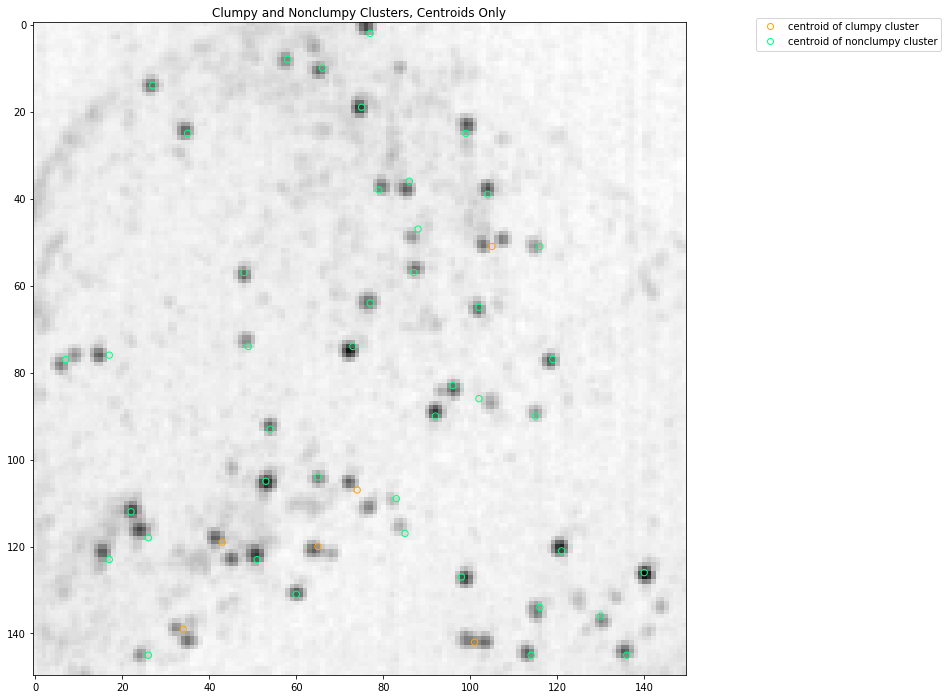

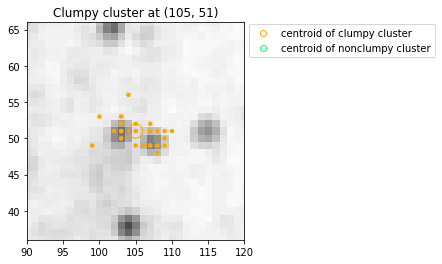

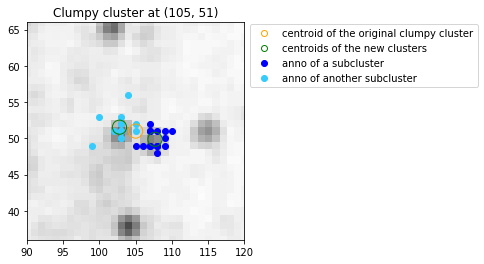

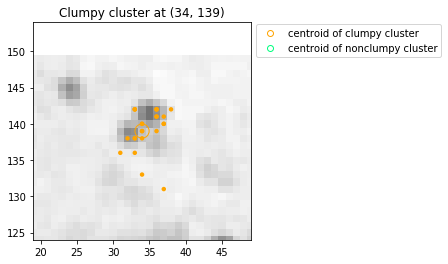

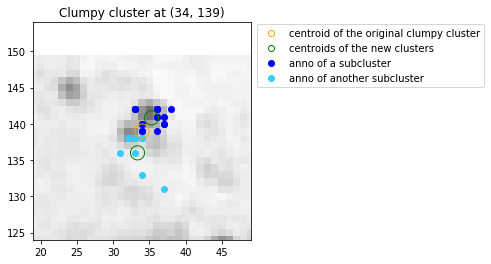

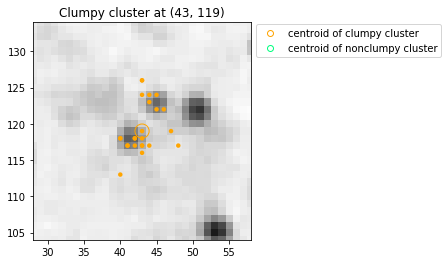

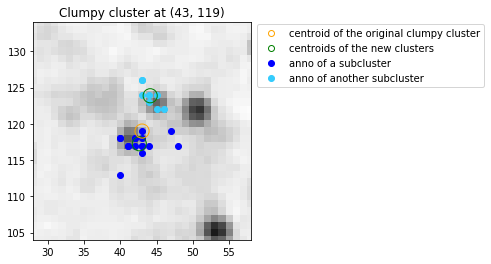

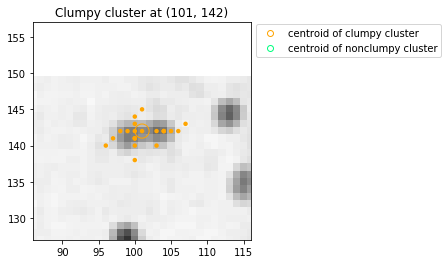

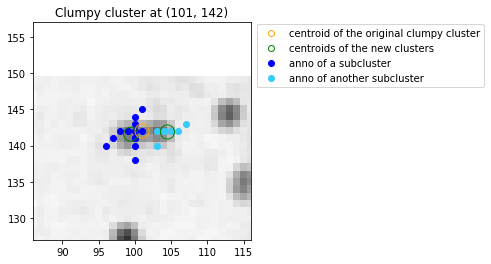

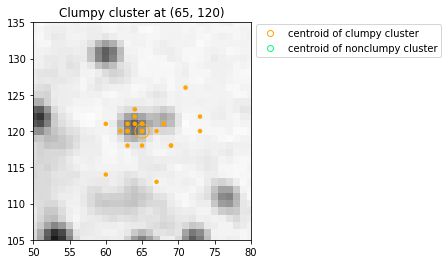

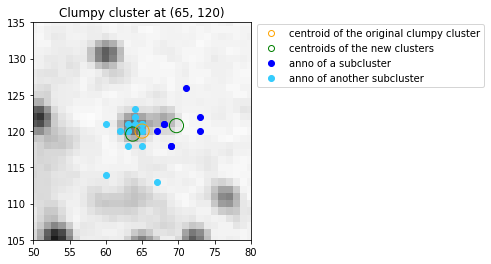

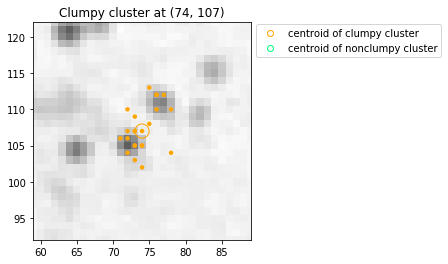

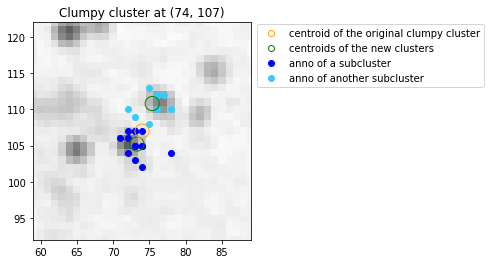

------------- C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop3.png -------------


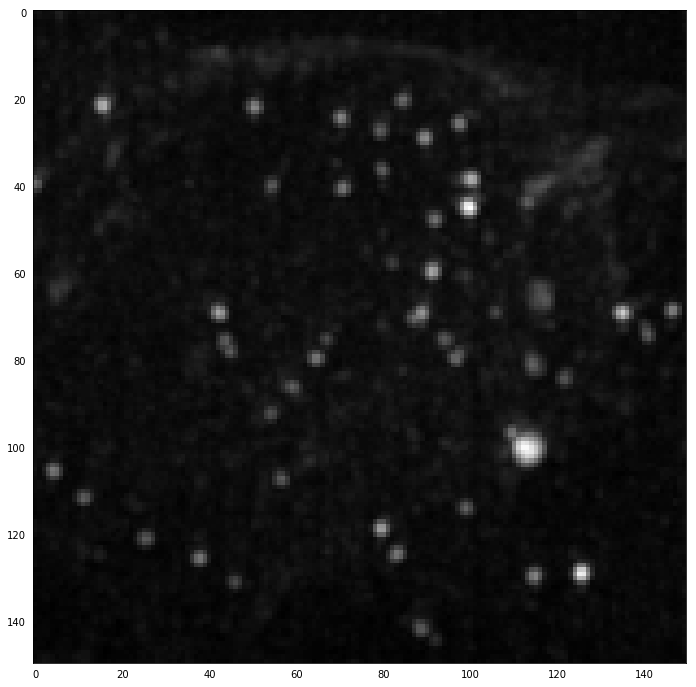

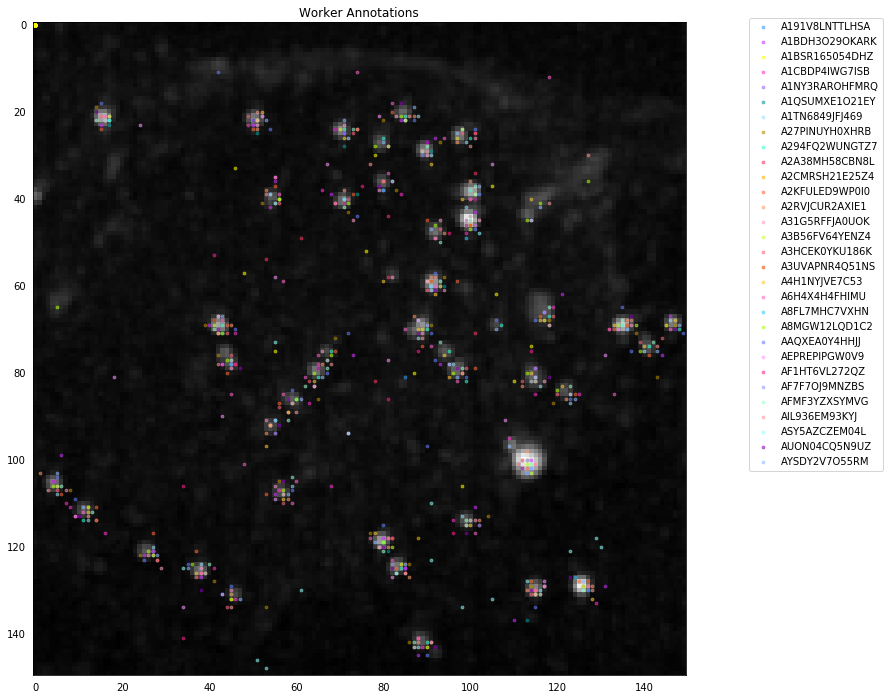

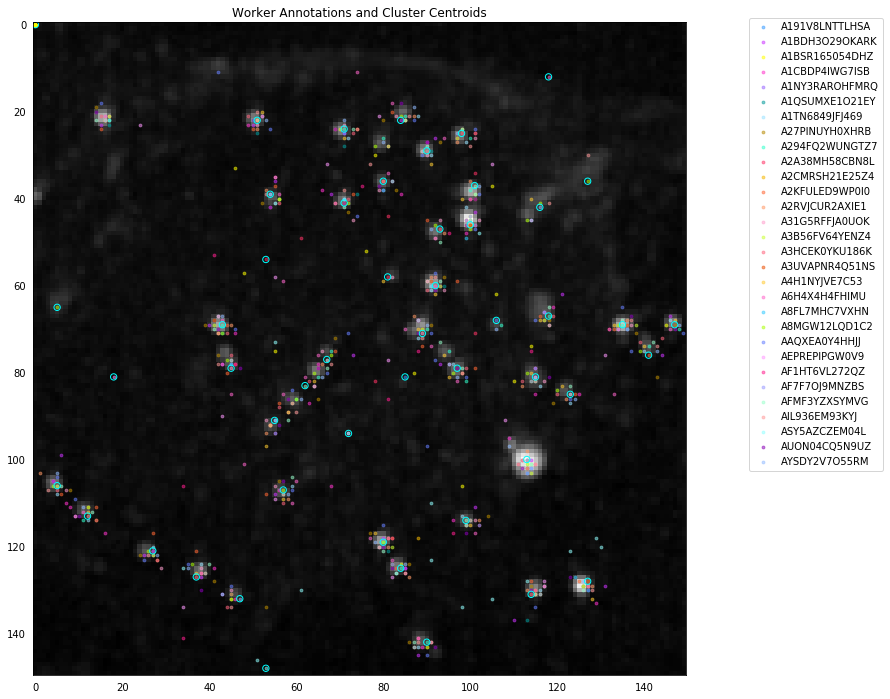

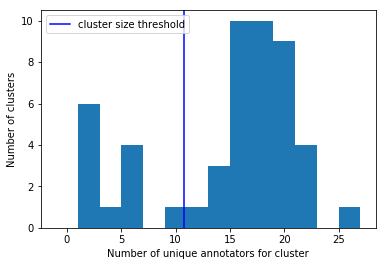

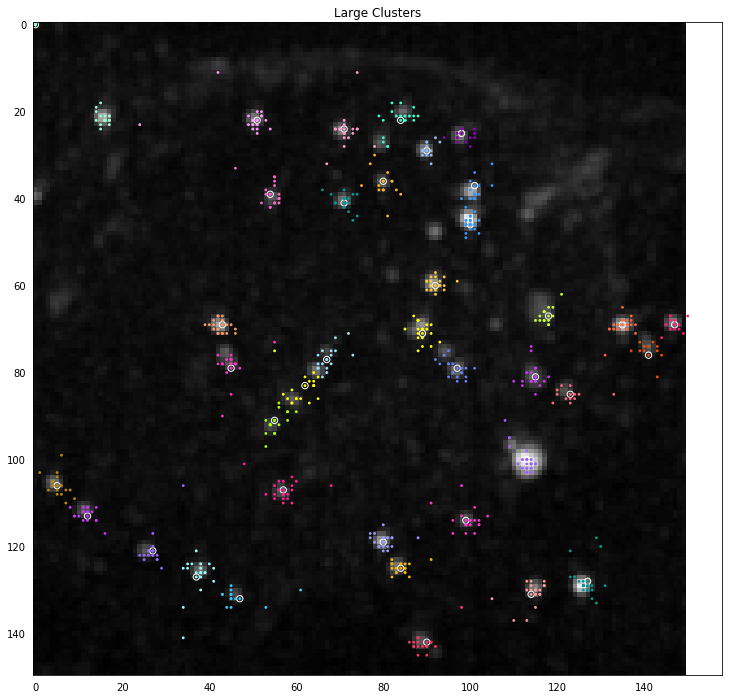

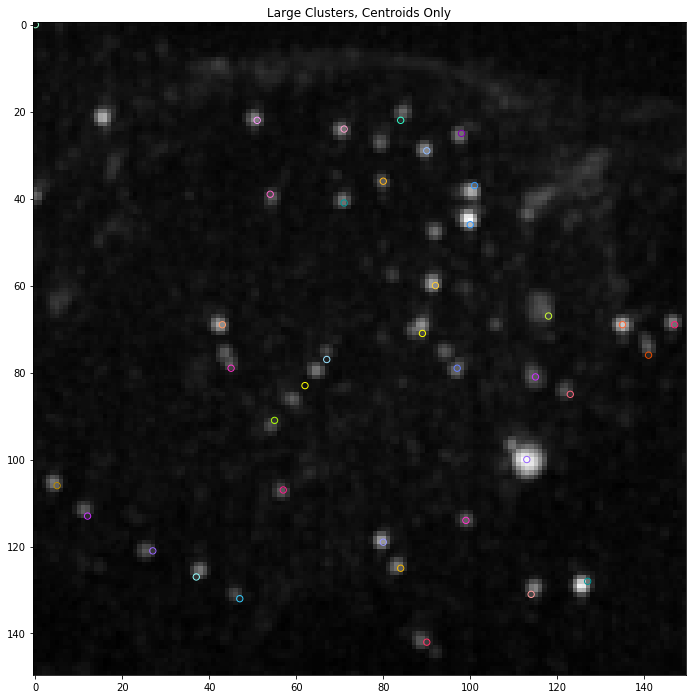

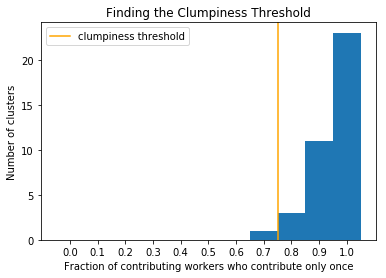

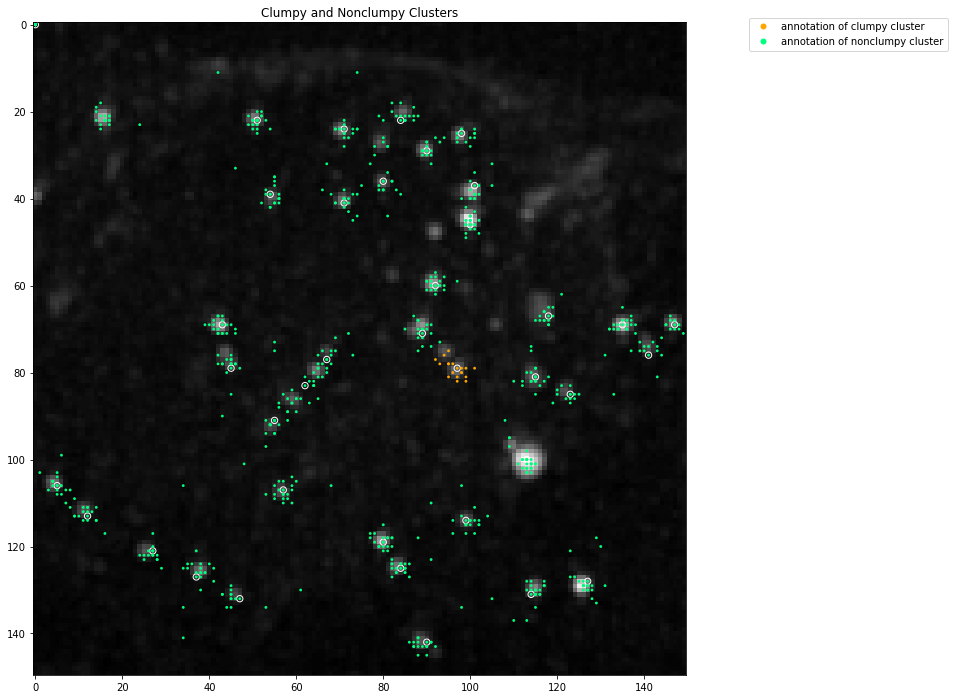

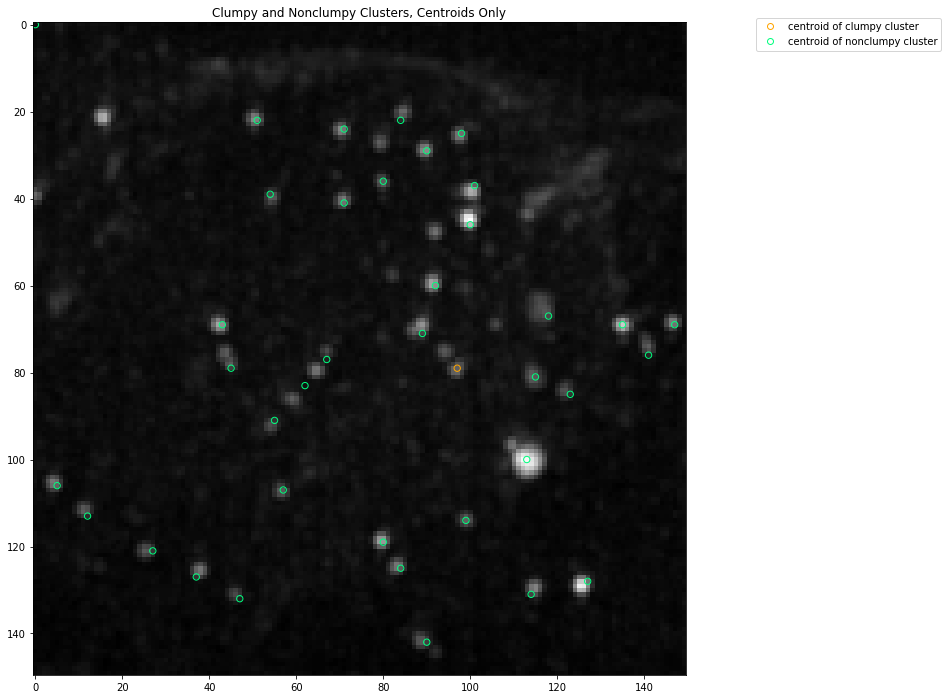

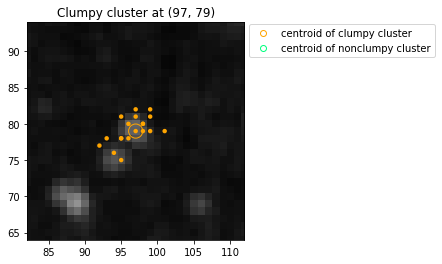

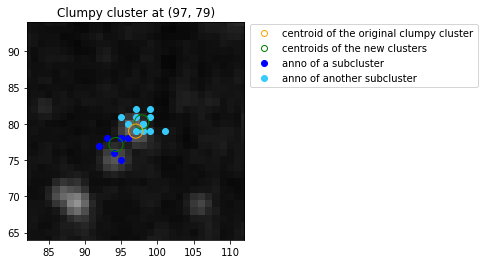

------------- C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop3_inv.png -------------


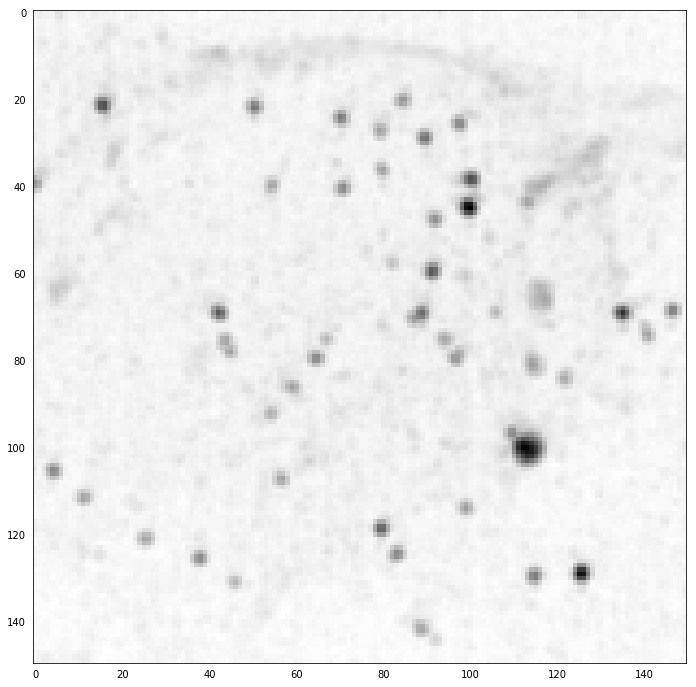

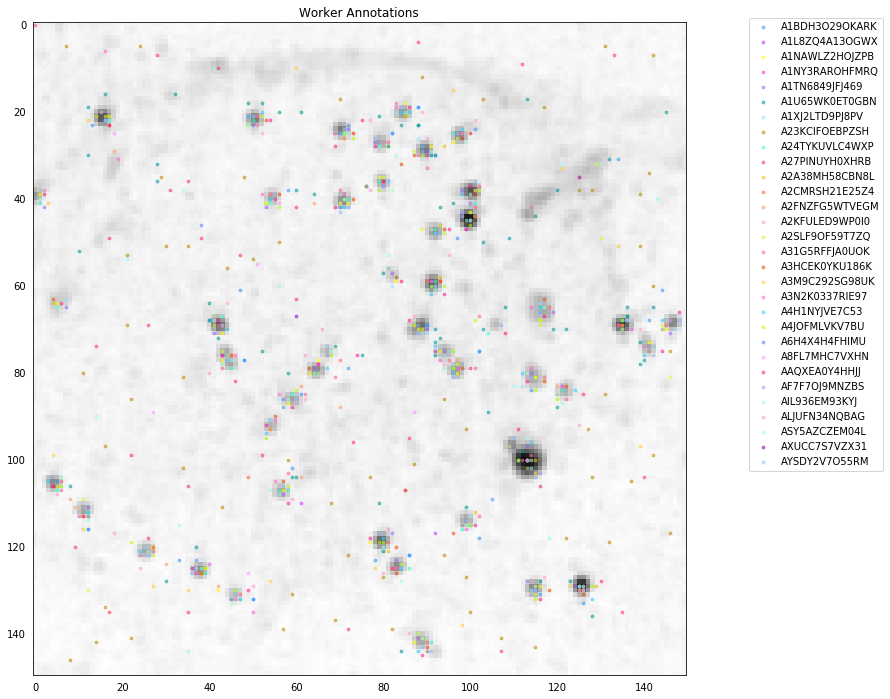

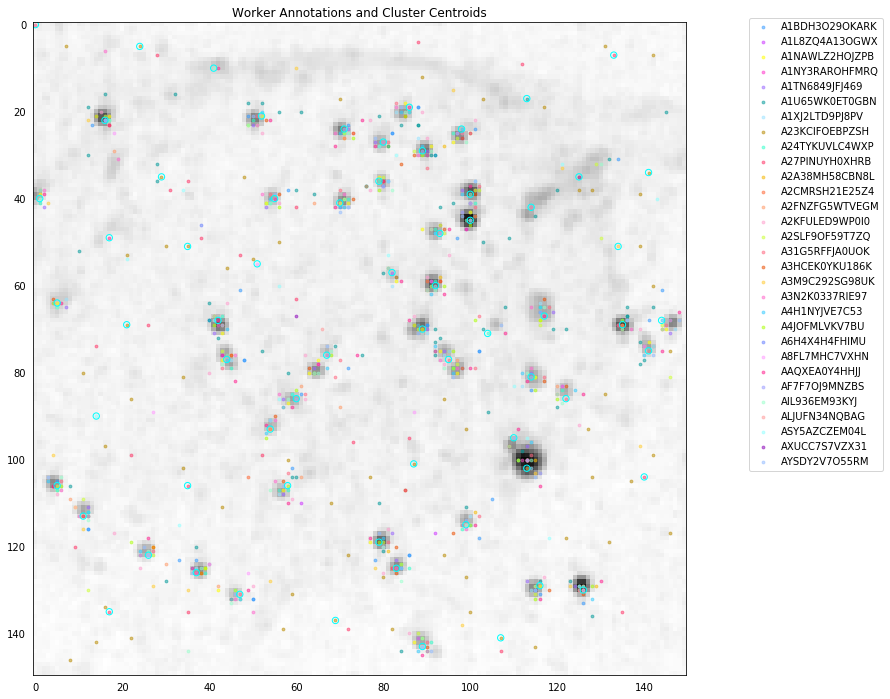

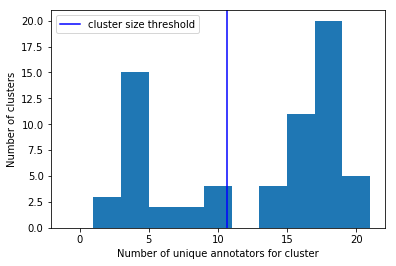

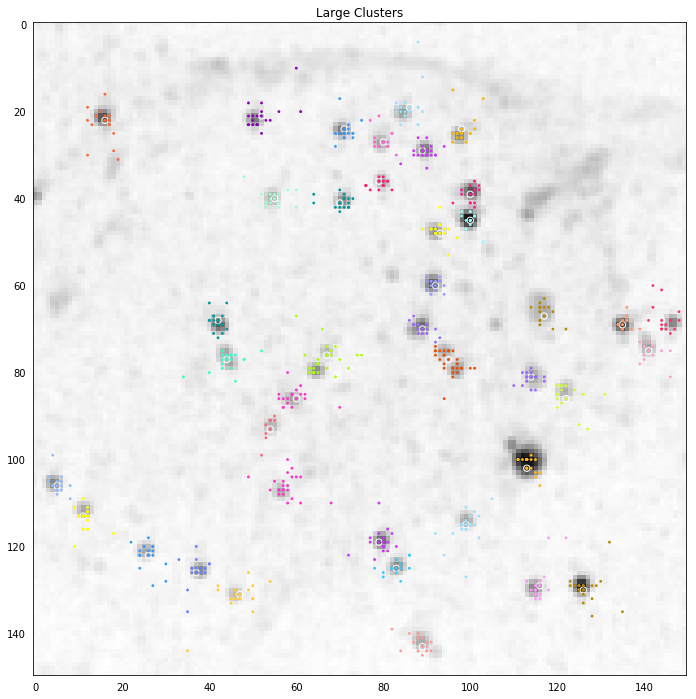

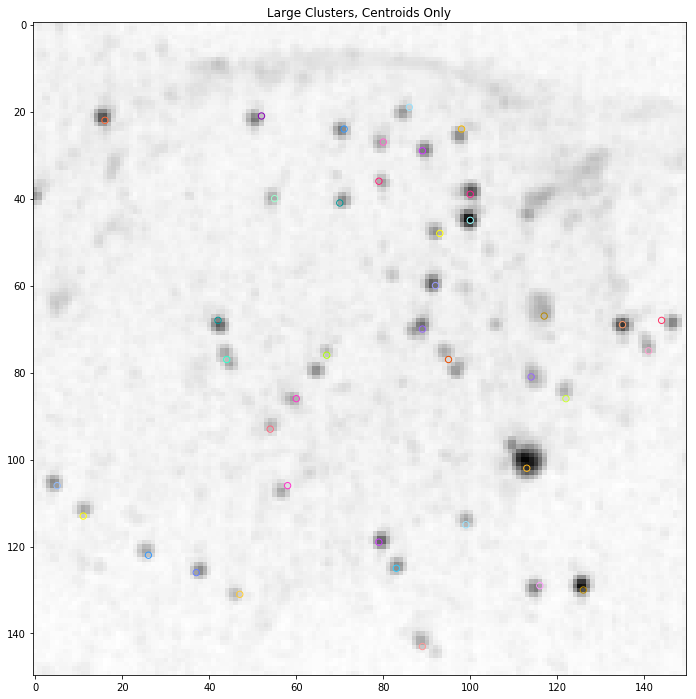

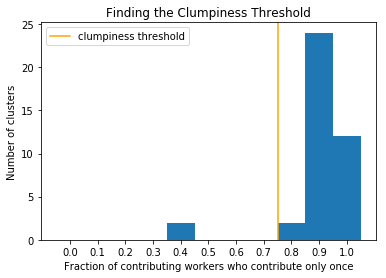

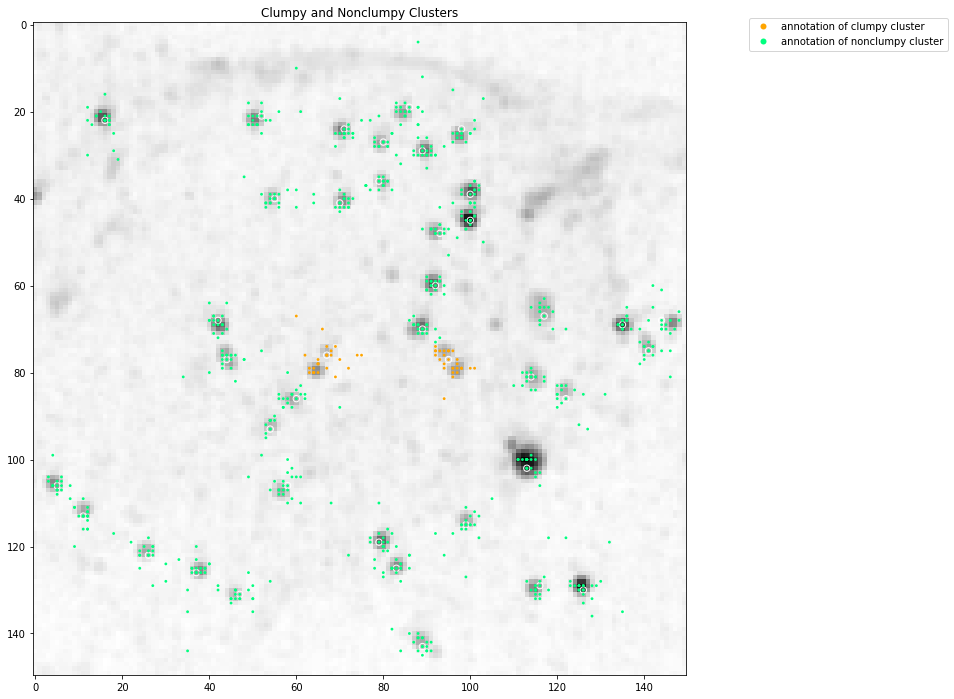

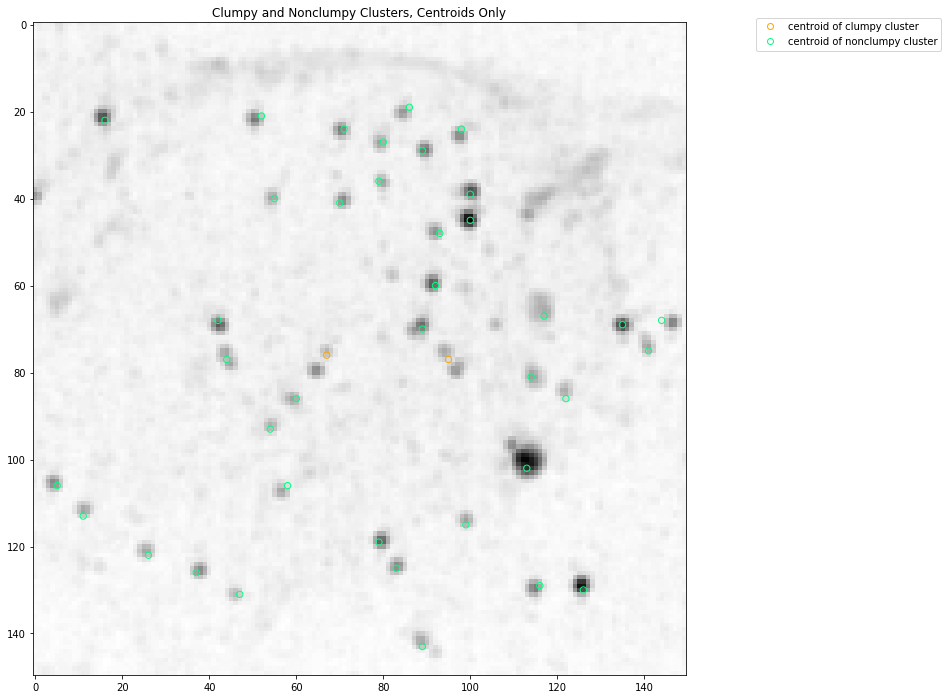

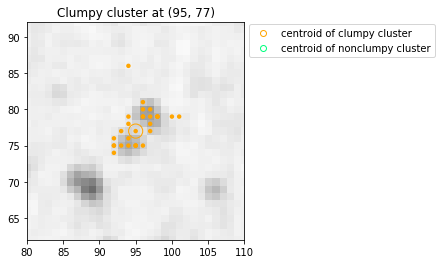

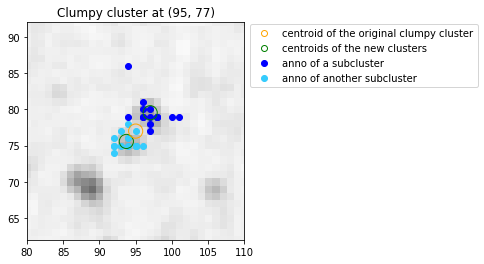

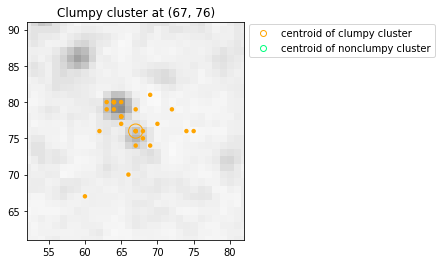

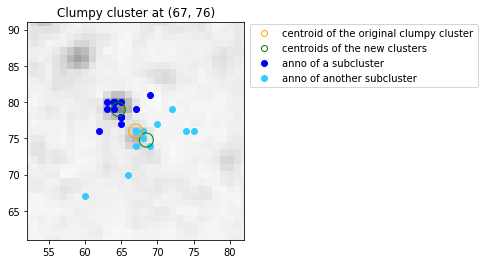

Number of non-clumpy centroids found
C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop1.png: 58 / 77 ref spots
C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop1_inv.png: 58 / 77 ref spots
C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop2.png: 52 / 64 ref spots
C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop2_inv.png: 55 / 64 ref spots
C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop3.png: 39 / 50 ref spots
C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop3_inv.png: 42 / 50 ref spots


In [2]:
json_filename_list = ['Density_test_2.json']

num_clusters_total_list = []
img_filename_list = ['C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop1.png',
                    'C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop1_inv.png',
                    'C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop2.png',
                    'C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop2_inv.png',
                    'C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop3.png',
                    'C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700_crop3_inv.png']
csv_filename_list = ['crop1.csv', 'crop1.csv', 'crop2.csv', 'crop2.csv', 'crop3.csv', 'crop3.csv']
csv_filepath_list = []
for json_filename in json_filename_list:
    for csv_filename, img_filename in zip(csv_filename_list, img_filename_list):
        
        img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/Density_test_2/'+img_filename
        json_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/Density_test_2/'+json_filename
        csv_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/Density_test_2/'+csv_filename
        print('------------- ' + img_filename + ' -------------')
        
        ba = QuantiusAnnotation(json_filepath)
        sa = SpotAnnotationAnalysis(ba)
        anno_all = ba.df()
        anno_one_image = ba.slice_by_image(anno_all, img_filename)
        show_workers = False
        show_clusters = False
        clustering_params = None
        sa.plot_annotations(anno_one_image, img_filename, img_filepath, csv_filepath, worker_marker_size, cluster_marker_size, show_ref_points, show_workers, show_clusters, show_correctness_workers, show_correctness_clusters, show_NN_inc, correctness_threshold, clustering_params, bigger_window_size)
        
        show_workers = True
        sa.plot_annotations(anno_one_image, img_filename, img_filepath, csv_filepath, worker_marker_size, cluster_marker_size, show_ref_points, show_workers, show_clusters, show_correctness_workers, show_correctness_clusters, show_NN_inc, correctness_threshold, clustering_params, bigger_window_size)
        
        show_clusters = True
        clustering_params = ['AffinityPropagation', -350]
        clusters = sa.plot_annotations(anno_one_image, img_filename, img_filepath, csv_filepath, worker_marker_size, cluster_marker_size, show_ref_points, show_workers, show_clusters, show_correctness_workers, show_correctness_clusters, show_NN_inc, correctness_threshold, clustering_params, bigger_window_size)

        # Get large clusters
        threshold = sa.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = sa.sort_clusters_by_size(clusters, threshold)
        
        # Show cluster size threshold
        fig = plt.figure()
        hist_list = []
        for i in range(len(clusters.index)):
            row = clusters.iloc[[i]]
            members = row.iloc[0]['members']
            worker_list = []
            for member in members:
                worker_list.append(member[3])
            num_members = len(np.unique(worker_list))
            hist_list.append(num_members)
        width = max(hist_list)
        plt.hist(hist_list, bins=np.arange(0,width+4,2)-1)
        plt.axvline(x=threshold, color='b')
        kmeans_line = Line2D([0],[0], color='b', label='cluster size threshold')
        plt.legend(handles=[kmeans_line])
        plt.xlabel('Number of unique annotators for cluster')
        plt.ylabel('Number of clusters')
        plt.show()
        
        # plot centroids and annotations
        fig = plt.figure(figsize=(14,12))
        
        centroid_x_list = large_clusters['centroid_x'].values
        centroid_y_list = large_clusters['centroid_y'].values
        centroid_y_list_flipped = ba.flip(centroid_y_list, img_height)
        plt.scatter(centroid_x_list, centroid_y_list_flipped, s = cluster_marker_size, facecolors = 'none', edgecolors = '#ffffff')
        
        img = mpimg.imread(img_filepath)
        plt.imshow(img, cmap = 'gray')

        plt.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            right=False)
        
        member_lists = large_clusters['members'].values
        for color, member_list in zip(sa.colors*10, member_lists):
            for member in member_list:
                plt.scatter([member[0]], [img_height-member[1]], s = worker_marker_size, facecolors = color, edgecolors = 'None')
        plt.title('Large Clusters')
        plt.show()
        
        # plot centroids only
        fig = plt.figure(figsize=(14,12))
        
        for color, centroid_x, centroid_y in zip(sa.colors*10, centroid_x_list, centroid_y_list):
            plt.scatter([centroid_x], [img_height-centroid_y], s = cluster_marker_size, facecolors = 'none', edgecolors = color)
        img = mpimg.imread(img_filepath)
        plt.imshow(img, cmap = 'gray')

        plt.title('Large Clusters, Centroids Only')
        plt.show()

        # Calc clumpiness threshold
        single_fraction_list = []
        for i in range(len(large_clusters.index)):
            row = large_clusters.iloc[[i]]
            members = row.iloc[0]['members']
            workers = []
            x_coords = []
            y_coords = []
            for member in members:
                x_coords.append(member[0])
                y_coords.append(member[1])
                workers.append(member[3])

            # Calculate replication of unique workers for each cluster
            unique_workers = np.unique(workers)
            num_instances_list = []
            for unique_worker in unique_workers:
                num_instances_list.append(workers.count(unique_worker))
            singles = num_instances_list.count(1)
            single_fraction = singles/len(unique_workers)
            single_fraction_list.append(single_fraction)

        # plot single fraction histogram
        fig = plt.figure()
        (n, bins, patches) = plt.hist(single_fraction_list, bins = np.arange(0,1.2,0.1)-0.05)

        # calc drop-off threshold
        total_counts = n
#         print('counts:')
#         print(total_counts)
        total_counts_rev = list(reversed(total_counts))

        threshold_drop = 0
        prev_count = 0
        for i in range(len(total_counts_rev)):
            count = total_counts_rev[i]
            if (count != 0):
                if((count < prev_count/3) and (count != 0) and (prev_count != 0)):
                    threshold_drop = 1-i*0.1-0.05
            prev_count = count

        plt.xlabel('Fraction of contributing workers who contribute only once')
        plt.ylabel('Number of clusters')
        plt.xticks(np.arange(0,1.1, 0.1))
        drop_line = Line2D([0],[0], color='orange', label='clumpiness threshold')
        plt.legend(handles=[drop_line])
        plt.axvline(x=threshold_drop, color='orange')
        plt.title('Finding the Clumpiness Threshold')
        plt.show()

        # sort clusters by predicted clumpiness
        clumpy_clusters, nonclumpy_clusters = sa.sort_clusters_by_clumpiness(large_clusters, threshold_drop)
        
        # Plot clumpy and nonclumpy clusters

        fig = plt.figure(figsize=(14,12))
        
        centroid_x_list = large_clusters['centroid_x'].values
        centroid_y_list = large_clusters['centroid_y'].values
        centroid_y_list_flipped = ba.flip(centroid_y_list, img_height)
        plt.scatter(centroid_x_list, centroid_y_list_flipped, s = cluster_marker_size, facecolors = 'none', edgecolors = '#ffffff')
        
        clumpy_member_lists = clumpy_clusters['members'].values
        for member_list in clumpy_member_lists:
            for member in member_list:
                plt.scatter([member[0]], [img_height - member[1]], s = worker_marker_size, facecolors = 'orange', edgecolors = 'None')
        
        nonclumpy_member_lists = nonclumpy_clusters['members'].values
        for member_list in nonclumpy_member_lists:
            for member in member_list:
                plt.scatter([member[0]], [img_height - member[1]], s = worker_marker_size, facecolors = '#00FF7F', edgecolors = 'None')
        
        leg_elem_1 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='None', markerfacecolor='orange', label='annotation of clumpy cluster')
        leg_elem_2 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='None', markerfacecolor='#00FF7F', label='annotation of nonclumpy cluster')
        plt.legend(handles = [leg_elem_1, leg_elem_2], loc = 9, bbox_to_anchor = (1.25, 1.015))
        
        img = mpimg.imread(img_filepath)
        plt.imshow(img, cmap = 'gray')
        plt.title('Clumpy and Nonclumpy Clusters')
        
        plt.show()
        
        # Plot clumpy and nonclumpy clusters, centroids only
        
        fig = plt.figure(figsize=(14,12))        
        
        clumpy_centroid_x_list = clumpy_clusters['centroid_x'].values
        clumpy_centroid_y_list = clumpy_clusters['centroid_y'].values
        clumpy_centroid_y_list_flipped = ba.flip(clumpy_centroid_y_list, img_height)
        plt.scatter(clumpy_centroid_x_list, clumpy_centroid_y_list_flipped, s = cluster_marker_size, facecolors = 'none', edgecolors = 'orange')

        nonclumpy_centroid_x_list = nonclumpy_clusters['centroid_x'].values
        nonclumpy_centroid_y_list = nonclumpy_clusters['centroid_y'].values
        nonclumpy_centroid_y_list_flipped = ba.flip(nonclumpy_centroid_y_list, img_height)
        plt.scatter(nonclumpy_centroid_x_list, nonclumpy_centroid_y_list_flipped, s = cluster_marker_size, facecolors = 'none', edgecolors = '#00FF7F')
        
        leg_elem_1 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='orange', markerfacecolor='None', label='centroid of clumpy cluster')
        leg_elem_2 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#00FF7F', markerfacecolor='None', label='centroid of nonclumpy cluster')
        plt.legend(handles = [leg_elem_1, leg_elem_2], loc = 9, bbox_to_anchor = (1.25, 1.015))
        
        img = mpimg.imread(img_filepath)
        plt.imshow(img, cmap = 'gray')
        plt.title('Clumpy and Nonclumpy Clusters, Centroids Only')
        
        plt.show()
        
        num_new_clusters = 0
        for i in range(len(clumpy_clusters.index)):

            row = clumpy_clusters.iloc[[i]]
            centroid_x = row.iloc[0]['centroid_x']
            centroid_y = row.iloc[0]['centroid_y']
            
            # Show zoomed-in view of clumps
            
            margin = 15
            centroid_y_flipped = img_height-centroid_y
            fig = plt.figure()
            plt.imshow(img, cmap='gray')
            plt.xlim(centroid_x-margin, centroid_x+margin)
            plt.ylim(centroid_y_flipped-margin, centroid_y_flipped+margin)
            plt.title('Clumpy cluster at (' + str(centroid_x) + ', ' + str(centroid_y_flipped) + ')')
            
            members = row.iloc[0]['members']
            workers = []
            x_coords = []
            y_coords = []
            for member in members:
                workers.append(member[3])
                x_coords.append(member[0])
                y_coords.append(member[1])
            unique_workers = np.unique(workers)
            y_coords_flipped = ba.flip(y_coords, img_height)
            plt.scatter(x_coords, y_coords_flipped, s = 20, facecolors = 'orange', edgecolors = 'None')
            plt.scatter([centroid_x], [centroid_y_flipped], s = 200, facecolors = 'None', edgecolors = 'orange')
            
            leg_elem_1 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='orange', markerfacecolor='None', label='centroid of clumpy cluster')
            leg_elem_2 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#00FF7F', markerfacecolor='None', label='centroid of nonclumpy cluster')
            plt.legend(handles = [leg_elem_1, leg_elem_2], loc = 9, bbox_to_anchor = (1.45, 1.015))
            plt.show()
            
            # Show partitioning of clumps
            
            # partition the clumps
            k_values = [2]
            for k_value in k_values:

                # apply k-means
                coords = np.stack((x_coords, y_coords), axis=-1)
                km = KMeans(n_clusters=k_value).fit(coords)
                centers = km.cluster_centers_
                labels = km.labels_

                # visualize
                plt.imshow(img, cmap='gray')
                plt.xlim(centroid_x-margin, centroid_x+margin)
                plt.ylim(centroid_y_flipped-margin, centroid_y_flipped+margin)
                plt.title('Clumpy cluster at (' + str(centroid_x) + ', ' + str(centroid_y_flipped) + ')')
                # member annotations, colorized by membership in new clusters
                for coord, label in zip(coords, labels):
                    if(label == 0):
                        color = 'blue'
                    elif(label == 1):
                        color = '#35ccfd'
                    elif(label == 2):
                        color = '#4286f4'
                    plt.scatter([coord[0]],[img_height-coord[1]],color=color)
                # centroids of new clusters
                for center in centers:
                    plt.scatter([center[0]],[img_height-center[1]],edgecolors='green',facecolors='None',s=200)
                    num_new_clusters += 1
                # centroid of the original clumpy cluster
                plt.scatter([centroid_x],[img_height-centroid_y],edgecolors='orange',facecolors='None',s=200)

                # legend
                leg_elem_1 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='orange', markerfacecolor='None', label='centroid of the original clumpy cluster')
                leg_elem_2 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='green', markerfacecolor='None', label='centroids of the new clusters')
                leg_elem_3 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='blue', markerfacecolor='blue', label='anno of a subcluster')
                leg_elem_4 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#35ccfd', markerfacecolor='#35ccfd', label='anno of another subcluster')
                if (k_value == 2):
                    handle_list = [leg_elem_1, leg_elem_2, leg_elem_3, leg_elem_4]
                else:
                    leg_elem_5 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#4286f4', markerfacecolor='#4286f4', label='anno of another subcluster')
                    handle_list = [leg_elem_1, leg_elem_2, leg_elem_3, leg_elem_4, leg_elem_5]
                plt.legend(handles = handle_list, loc = 9, bbox_to_anchor = (1.55, 1.015))

                plt.show()

                if (num_instances_list.count(3) == 0):
                    break
                    
        num_clusters_total = len(nonclumpy_centroid_x_list) + num_new_clusters
        num_clusters_total_list.append(num_clusters_total)
        csv_filepath_list.append(csv_filepath)

print('Number of non-clumpy centroids found')
for img_filename, csv_filepath, num_clusters_total in zip(img_filename_list, csv_filepath_list, num_clusters_total_list):  
    ref_df = pd.read_csv(csv_filepath)
    ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
    print(img_filename + ': ' + str(num_clusters_total) + ' / ' + str(len(ref_points)) + ' ref spots')  
    